## Nonlinear MPC with Kinematic Bicycle Model

The bicycle model is the same one used in <a href=https://link-springer-com.stanford.idm.oclc.org/article/10.1007/s13177-020-00226-1#Tab4>this paper (Figure 3)</a>

The model has state and input:
\begin{gather*}
z = \begin{bmatrix}x\\ y\\ v\\ \psi\end{bmatrix},\quad
u = \begin{bmatrix}a\\ \delta_f\end{bmatrix},\quad
\end{gather*}

The 4 states are:
* $x$ and $y$, the car's position in the world frame
* $v$, the car's velocity
* $\psi$, the angle of the car's centerline in the world frame


The two control signals are $a$, the acceleration command, and $\delta_f$, the front steering angle (in radians).

$\beta$ is the angle between the car's centerline and its velocity vector. It is not really a state, but a function of $\delta_f$.

The nonlinear model is:
\begin{gather*}
\begin{bmatrix}
\dot x\\ \dot y\\ \dot v\\ \dot\psi
%\\ \dot\beta
\end{bmatrix} =
\begin{bmatrix}
v\cos(\psi + \beta)
\\
v\sin(\psi + \beta)
\\
a
\\
\frac{v}{l_r}\sin(\beta)
%\\
%\frac{v}{l_f + l_r}\tan(\delta_f) - \frac{v}{l_r}\sin(\beta)
\end{bmatrix}, \quad \beta = \tan^{-1}\Big(\frac{l_r}{l_r + l_f}\tan(\delta_f)\Big)
\end{gather*}


## Casadi setup
From http://casadi.sourceforge.net/v3.4.4/users_guide/casadi-users_guide.pdf

In [2]:
# Library dependencies
import casadi
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib        as mpl
import bezier

# Local dependencies
from direct_collocation  import MpcProblem
from KinematicBicycleCar import KinematicBicycleCar
from roadrunner_2        import Roadrunner, Segment
from road                import iso_double_lane_change as test_road

## Initialize the car and road model

In [3]:
# Initialize the car model with 0.05 second steps and 30 step lookahead
car = KinematicBicycleCar(N=30, step=0.075)

DESIRED_SPEED = 5.0

In [4]:
n_test_road_pts,_ = np.shape(test_road)

roadrunner = Roadrunner(road_center = test_road,                    # Road centerline points
                        road_width  = np.ones(n_test_road_pts)*5.0, # constant lane width of 5 meters
                        P           = 10) # Number of points to try curve-fitting at a time

## Boundary functions
We represent the road boundaries as a series of polygons. At each step $x_k$, $x_{k+1},...,x_N$, the car's x-y position is bounded by a 4-sided polygon.
The polygons for successive states overlap, allowing the car to steer and slow down / speed up within the confines of the road.

This image shows 5 successive bounds from $k$ to $k+5$. The $k+5^{th}$ bound is in red.
![title](polygon_bounds.png)

In [5]:
# terrible hack, need to fix right away

global dist_already_traveled
dist_already_traveled = 0.0

def road_center(model:KinematicBicycleCar, k:int)->np.array:
    global dist_already_traveled

    (xy, angle, _) = roadrunner.evaluate(model.step*np.sum(model.state_estimate[2,:k]), full_data=True)

    center = np.empty((3,))
    center[0:2] = np.reshape(xy, 2)
    center[2]   = angle
    return center

# Test

def bound_x(model:KinematicBicycleCar, k:int)->[np.array]:
    # Returns a 4-sided polygon bound, like this:
    # x2-------x3
    #   \  o  /
    #  x1-----x4
    # successive bounds will overlap each other
    # so there is freedom to slow down or speed up the vehicle.
    
    dist_behind = (k-5)*model.step*DESIRED_SPEED # 5 steps behind * timestep * velocity at point k
    #print("Looking behind by", dist_behind)
    (center_minus, angle_minus, width_minus) = roadrunner.evaluate(dist_behind, full_data=True)
    
    dist_ahead = (k+5)*model.step*DESIRED_SPEED # 5 steps ahead * timestep * velocity at point k
    #print("Looking ahead by", dist_ahead)
    (center_plus, angle_plus, width_plus) = roadrunner.evaluate(dist_ahead, full_data=True)

    center_minus = np.reshape(center_minus,(2,))
    center_plus = np.reshape(center_plus,(2,))
    
    #print("Got center points", center_minus, center_plus)
    #print("center angles:", 180.0/np.pi*(angle_minus), 180.0/np.pi*(angle_plus))
    # These four points define the 2d bounding box for the car at state xk
    
    p1 = np.reshape(np.array([center_minus[0] + width_minus/2.0*np.cos(angle_minus-np.pi/2),
                   center_minus[1] + width_minus/2.0*np.sin(angle_minus-np.pi/2)]), (2,))
    
    p2 = np.reshape(np.array([center_minus[0] + width_minus/2.0*np.cos(angle_minus+np.pi/2),
                   center_minus[1] + width_minus/2.0*np.sin(angle_minus+np.pi/2)]), (2,))
    
    p3 = np.reshape(np.array([center_plus[0] + width_plus/2.0*np.cos(angle_plus+np.pi/2),
                   center_plus[1] + width_plus/2.0*np.sin(angle_plus+np.pi/2)]), (2,))
    
    p4 = np.reshape(np.array([center_plus[0] + width_plus/2.0*np.cos(angle_plus-np.pi/2),
                   center_plus[1] + width_plus/2.0*np.sin(angle_plus-np.pi/2)]), (2,))
    
    # The slopes between the points
    slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isnan(slope12) else slope12
    slope23 = (p3[1]-p2[1])/(p3[0]-p2[0]); slope23 = 1e4 if np.isnan(slope23) else slope23
    slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isnan(slope43) else slope43
    slope14 = (p1[1]-p4[1])/(p1[0]-p4[0]); slope14 = 1e4 if np.isnan(slope14) else slope14

    # form 4 linear inequalities to represent the box
    # we either have 0.0 >= ax + by + c >= -Inf
    # or             Inf >= ax + by + c >= 0.0
    
    # since y = (x-x0)*slope + y0
    # use the line 0 = x*slope - y + y0 - x0*slope as the upper / lower bound
    
    #            (upper)
    #     p2-----slope23------p3
    #    /                    /
    # slope12 (upper)   slope34 (lower)
    #  /                   /
    # p1-----slope14-----p4
    #        (lower)
    
    # upper bounds (if slope is positive)
    bounds = [
        np.array([np.inf, slope12, -1.0, (p1[1]-p1[0]*slope12), 0.0 - 0]),
        np.array([np.inf, slope23, -1.0, (p2[1]-p2[0]*slope23), 0.0 - 3]),
    
    # lower bounds (if slope is positive)
        np.array([0.0 + 0, slope43, -1.0, (p4[1]-p4[0]*slope43), -np.inf]),
        np.array([0.0 + 3, slope14, -1.0, (p1[1]-p1[0]*slope14), -np.inf]),
    ]
    
    for i in range(len(bounds)): # Handle the negative-slope flipped cases
    
        if np.sign(bounds[i][1]) == -1: # slope is negative, so inequality flips
            bounds[i][0], bounds[i][4] = -bounds[i][4], -bounds[i][0]
            
    return bounds, np.vstack([p1,p2,p3,p4])

In [6]:
# What we should do now
# 1. Use the velocity estimate to "step through" the road,
#    obtaining a set of road midpoints and constraint boundaries
# 2. Add a term to the cost function that attracts the successive states to the road midpoints - done
# 3. Use the midpoints to initialize the variable estimate so the solver is faster. - done,
#    and we are initializing the new control uk to the previously computed one
#    kind of warm-starting ipopt - done

## Run the MPC algorithm

In [7]:
roadrunner.reset()
# start a bit ahead of the first point to have space for looking back on the road
roadrunner.advance(car.step*5*DESIRED_SPEED)

xy = np.reshape(roadrunner.evaluate(),(2,))
ic = [xy[0], xy[1], DESIRED_SPEED, float(roadrunner.get_angle())]
car.set_initial(ic)
print("Starting at initial conditions", ic)

# This is the model:
# https://link-springer-com.stanford.idm.oclc.org/article/10.1007/s13177-020-00226-1/figures/3
mpcprob = MpcProblem(car,     # casadi.DaeBuilder()
                     bound_x=bound_x,
                     road_center=road_center,
                    )


# Controls the NUMBER of iterations to run the MPC algorithm.
n_runs = 350

x_plan = np.empty((mpcprob.model.n,n_runs+1)) # store the steps that get executed (n_runs)
u_plan = np.empty((mpcprob.model.m,n_runs))   # store the control inputs that get executed
x_true = np.empty((mpcprob.model.n,n_runs+1)) # store the state as simulated for each control input by an integrator
x_true[:,0] = ic # initial conditions
x_plan[:,0] = ic
# store the polygon boundary for each step, so we can plot them later
polygon_boundaries = np.zeros((n_runs+mpcprob.model.N,4,2))

for k in range(n_runs):
    # Solve the MPC problem
    xk_opt, uk_opt, sol = mpcprob.run(x_true[:,k])
    
    # Save the next state x_k+1 and control u_k+1
    for i in range(mpcprob.model.n):
        x_plan[i,k+1] = xk_opt[i][1]
    for i in range(mpcprob.model.m):
        u_plan[i,k] = uk_opt[i][1]
    x_true[:,k+1] = mpcprob.simulate(x_true[:,k], u_plan[:,k])
    
    # Compute distance traveled (approximately)
    step_xy = np.linalg.norm(x_true[:,k+1]-x_true[:,k], 2) #np.sqrt((x_true[0,k+1]-x_true[0,k])**2 + (x_true[1,k+1]-x_true[1,k])**2)
    
    # Save the 4 points that represent the polygon boundary at state k
    bounds,p = bound_x(mpcprob.model,0)
    polygon_boundaries[k,:,:] = p
    
    roadrunner.advance(step_xy)
    print("Advanced by", step_xy,"to", roadrunner.evaluate())

    # Done!

Starting at initial conditions [7.205005423423943, 0.9507276608817815, 5.0, 0.002078667450380319]
Attracting  X_1[0] 1 to  [7.58994220e+00 9.51544460e-01 2.07866745e-03]
Attracting  X_2[0] 2 to  [7.97339342e+00 9.52390214e-01 2.07866745e-03]
Attracting  X_3[0] 3 to  [8.35529335e+00 9.53264014e-01 2.07866745e-03]
Attracting  X_4[0] 4 to  [8.73556648e+00 9.54166553e-01 2.07866745e-03]
Attracting  X_5[0] 5 to  [9.11412869e+00 9.55100336e-01 2.07866745e-03]
Attracting  X_6[0] 6 to  [9.49088901e+00 9.56069903e-01 2.07866745e-03]
Attracting  X_7[0] 7 to  [9.86575201e+00 9.57082054e-01 2.07866745e-03]
Attracting  X_8[0] 8 to  [1.02386208e+01 9.58146074e-01 2.07866745e-03]
Attracting  X_9[0] 9 to  [1.06094001e+01 9.59273960e-01 2.07866745e-03]
Attracting  X_10[0] 10 to  [1.09780008e+01 9.60480648e-01 2.07866745e-03]
Attracting  X_11[0] 11 to  [1.13443435e+01 9.61784222e-01 2.07866745e-03]
Attracting  X_12[0] 12 to  [1.17083631e+01 9.63206131e-01 2.07866745e-03]
Attracting  X_13[0] 13 to  [1.20

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  5.9683626e+00 3.78e-01 1.15e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  3.6943450e+00 1.39e-05 4.97e-01  -1.0 3.30e+01    -  5.76e-01 1.00e+00f  1
   2  2.3874826e+00 1.93e-06 1.02e-01  -1.0 2.23e+00    -  8.63e-01 1.00e+00f  1
   3  9.3287404e-01 1.60e-06 2.33e-03  -1.0 5.56e+00    -  9.68e-01 1.00e+00f  1
   4  5.2311215e-0

Attracting  X_23[0] 23 to  [16.0763551   1.02837412  0.03094028]
Attracting  X_24[0] 24 to  [16.41543418  1.03941148  0.03415969]
Attracting  X_25[0] 25 to  [16.75884856  1.05172563  0.03754626]
Attracting  X_26[0] 26 to  [17.10681973  1.06541294  0.04110316]
Attracting  X_27[0] 27 to  [17.45945642  1.08057092  0.04483439]
Attracting  X_28[0] 28 to  [17.81678119  1.09729835  0.04874495]
Attracting  X_29[0] 29 to  [18.17875609  1.11569584  0.05284089]
Attracting  X_30[0] 30 to  [18.54530549  1.13586657  0.05712933]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                

Attracting  X_1[0] 1 to  [9.49503596e+00 9.56080825e-01 2.51912753e-03]
Attracting  X_2[0] 2 to  [9.86476392e+00 9.57079315e-01 2.51912753e-03]
Attracting  X_3[0] 3 to  [1.02290643e+01 9.58117988e-01 2.51912753e-03]
Attracting  X_4[0] 4 to  [1.05871868e+01 9.59204143e-01 2.51912753e-03]
Attracting  X_5[0] 5 to  [1.09383825e+01 9.60346289e-01 2.51912753e-03]
Attracting  X_6[0] 6 to  [1.12819918e+01 9.61554037e-01 2.51912753e-03]
Attracting  X_7[0] 7 to  [1.16175120e+01 9.62837988e-01 2.51912753e-03]
Attracting  X_8[0] 8 to  [1.19446470e+01 9.64209649e-01 2.51912753e-03]
Attracting  X_9[0] 9 to  [1.22633374e+01 9.65681445e-01 2.51912753e-03]
Attracting  X_10[0] 10 to  [1.25737738e+01 9.67266864e-01 2.51912753e-03]
Attracting  X_11[0] 11 to  [1.28763945e+01 9.68980766e-01 2.51912753e-03]
Attracting  X_12[0] 12 to  [1.31718699e+01 9.70839851e-01 2.51912753e-03]
Attracting  X_13[0] 13 to  [1.34610755e+01 9.72863262e-01 2.51912753e-03]
Attracting  X_14[0] 14 to  [1.37450566e+01 9.75073299e-0

Attracting  X_2[0] 2 to  [1.05830430e+01 9.59191153e-01 2.77384560e-03]
Attracting  X_3[0] 3 to  [1.09268932e+01 9.60307547e-01 2.77384560e-03]
Attracting  X_4[0] 4 to  [1.12620153e+01 9.61481049e-01 2.77384560e-03]
Attracting  X_5[0] 5 to  [1.15880531e+01 9.62720595e-01 2.77384560e-03]
Attracting  X_6[0] 6 to  [1.19047812e+01 9.64035426e-01 2.77384560e-03]
Attracting  X_7[0] 7 to  [1.22121542e+01 9.65435081e-01 2.77384560e-03]
Attracting  X_8[0] 8 to  [1.25103374e+01 9.66929517e-01 2.77384560e-03]
Attracting  X_9[0] 9 to  [1.27997211e+01 9.68529387e-01 2.77384560e-03]
Attracting  X_10[0] 10 to  [1.30809195e+01 9.70246472e-01 2.77384560e-03]
Attracting  X_11[0] 11 to  [1.33547573e+01 9.72094254e-01 2.77384560e-03]
Attracting  X_12[0] 12 to  [1.36222456e+01 9.74088604e-01 2.77384560e-03]
Attracting  X_13[0] 13 to  [1.38845487e+01 9.76248517e-01 2.77384560e-03]
Attracting  X_14[0] 14 to  [1.41429456e+01 9.78596878e-01 2.77384560e-03]
Attracting  X_15[0] 15 to  [1.43987871e+01 9.81161191e

Attracting  X_23[0] 23 to  [16.97935806  1.06025519  0.03978579]
Attracting  X_24[0] 24 to  [17.31155219  1.07405266  0.04325396]
Attracting  X_25[0] 25 to  [17.65496104  1.08954949  0.04695776]
Attracting  X_26[0] 26 to  [18.00917152  1.10689152  0.05090495]
Attracting  X_27[0] 27 to  [18.37365898  1.12622473  0.0551033 ]
Attracting  X_28[0] 28 to  [18.74793216  1.14770165  0.05956208]
Attracting  X_29[0] 29 to  [19.1316675   1.17149071  0.06429337]
Attracting  X_30[0] 30 to  [19.52468665  1.19777871  0.06931151]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                

Attracting  X_18[0] 18 to  [16.00766663  1.02627012  0.03030364]
Attracting  X_19[0] 19 to  [16.31946438  1.03617637  0.03323575]
Attracting  X_20[0] 20 to  [16.64337717  1.04745485  0.03639367]
Attracting  X_21[0] 21 to  [16.97874723  1.06023087  0.03977952]
Attracting  X_22[0] 22 to  [17.32446237  1.07461231  0.04339102]
Attracting  X_23[0] 23 to  [17.67905577  1.09068494  0.04722217]
Attracting  X_24[0] 24 to  [18.04085337  1.10851138  0.05126433]
Attracting  X_25[0] 25 to  [18.40817262  1.12813548  0.05550814]
Attracting  X_26[0] 26 to  [18.77957483  1.14959468  0.05994603]
Attracting  X_27[0] 27 to  [19.15409963  1.17293811  0.06457505]
Attracting  X_28[0] 28 to  [19.53124732  1.19823445  0.06939678]
Attracting  X_29[0] 29 to  [19.91078394  1.22556721  0.07441486]
Attracting  X_30[0] 30 to  [20.29260494  1.25502943  0.07963271]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of no

Attracting  X_17[0] 17 to  [16.36296019  1.0376316   0.03365327]
Attracting  X_18[0] 18 to  [16.68296037  1.04890385  0.0367872 ]
Attracting  X_19[0] 19 to  [17.01443393  1.06165778  0.04014665]
Attracting  X_20[0] 20 to  [17.35634596  1.07600206  0.04373025]
Attracting  X_21[0] 21 to  [17.70725564  1.09202197  0.04753237]
Attracting  X_22[0] 22 to  [18.06542157  1.1097754   0.05154375]
Attracting  X_23[0] 23 to  [18.42894267  1.12929211  0.05575239]
Attracting  X_24[0] 24 to  [18.79593464  1.15057819  0.06014498]
Attracting  X_25[0] 25 to  [19.16474117  1.17362696  0.06470888]
Attracting  X_26[0] 26 to  [19.53417831  1.19843824  0.0694349 ]
Attracting  X_27[0] 27 to  [19.9035702   1.22502976  0.07431792]
Attracting  X_28[0] 28 to  [20.27257869  1.2534341   0.07935481]
Attracting  X_29[0] 29 to  [20.64106932  1.28369443  0.08454253]
Attracting  X_30[0] 30 to  [21.00901468  1.31585977  0.08987648]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.7775559e+00 8.92e-08 1.06e-02  -3.8 2.00e-01    -  1.00e+00 8.78e-01f  1
  11  2.7775489e+00 2.25e-09 5.11e-08  -3.8 2.88e-02    -  1.00e+00 1.00e+00f  1
  12  2.7772453e+00 4.90e-11 9.54e-05  -5.7 1.40e-02    -  1.00e+00 9.94e-01f  1
  13  2.7772440e+00 5.61e-14 1.84e-11  -5.7 2.05e-04    -  1.00e+00 1.00e+00f  1
  14  2.7772403e+00 5.90e-14 1.83e-12  -8.6 1.74e-04    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 14

                                   (scaled)                 (unscaled)
Objective...............:   2.7772402782216314e+00    2.7772402782216314e+00
Dual infeasibility......:   1.8321498044222904e-12    1.8321498044222904e-12
Constraint violation....:   5.9008353758827070e-14    5.9008353758827070e-14
Complementarity.........:   2.8206769861783270e-09    2.8206769861783270e-09
Overall NLP error.......:   2.8206769861783270e-09    2.8206769861783270e-09


Number of objective funct

Attracting  X_30[0] 30 to  [22.02179279  1.4149187   0.10528298]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    i

Attracting  X_18[0] 18 to  [18.2739561   1.12078341  0.05394093]
Attracting  X_19[0] 19 to  [18.60057034  1.13904551  0.05778841]
Attracting  X_20[0] 20 to  [18.93449862  1.15903993  0.06184187]
Attracting  X_21[0] 21 to  [19.27542436  1.18087681  0.06610842]
Attracting  X_22[0] 22 to  [19.62297218  1.20466521  0.07059419]
Attracting  X_23[0] 23 to  [19.97674546  1.23051427  0.0753041 ]
Attracting  X_24[0] 24 to  [20.3363656   1.25853499  0.08024159]
Attracting  X_25[0] 25 to  [20.70151142  1.2888429   0.08540831]
Attracting  X_26[0] 26 to  [21.07195772  1.32156155  0.09080391]
Attracting  X_27[0] 27 to  [21.44758548  1.35682437  0.09642539]
Attracting  X_28[0] 28 to  [21.82836391  1.39477382  0.10226625]
Attracting  X_29[0] 29 to  [22.21433178  1.43555983  0.10831571]
Attracting  X_30[0] 30 to  [22.6055784   1.47933744  0.11455823]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of no

   9  5.7234072e-01 7.27e-08 8.43e-03  -3.8 4.00e-02    -  1.00e+00 5.78e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.7281670e-01 3.57e-09 8.45e-08  -3.8 1.03e-02    -  1.00e+00 1.00e+00f  1
  11  5.7230557e-01 8.59e-11 3.65e-05  -5.7 4.41e-03    -  1.00e+00 9.85e-01f  1
  12  5.7230742e-01 9.15e-14 1.84e-11  -5.7 9.79e-05    -  1.00e+00 1.00e+00f  1
  13  5.7230557e-01 4.99e-14 1.77e-12  -8.6 5.35e-05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 13

                                   (scaled)                 (unscaled)
Objective...............:   5.7230556549772438e-01    5.7230556549772438e-01
Dual infeasibility......:   1.7659540267049199e-12    1.7659540267049199e-12
Constraint violation....:   4.9904524956900786e-14    4.9904524956900786e-14
Complementarity.........:   3.4355611201916198e-09    3.4355611201916198e-09
Overall NLP error.......:   3.4355611201916198e-09    3.4355611201916198e-09


Number of objective funct

Attracting  X_28[0] 28 to  [22.59900301  1.47858121  0.11445254]
Attracting  X_29[0] 29 to  [22.97814712  1.52334145  0.12058215]
Attracting  X_30[0] 30 to  [23.3631064   1.57121259  0.12686142]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constra

Advanced by 0.2687276692734871 to [[14.65756051  0.9840219 ]]
Attracting  X_1[0] 1 to  [1.49039248e+01 9.87018852e-01 1.16065177e-02]
Attracting  X_2[0] 2 to  [1.51490045e+01 9.90288363e-01 1.16065177e-02]
Attracting  X_3[0] 3 to  [1.53932146e+01 9.93855543e-01 1.16065177e-02]
Attracting  X_4[0] 4 to  [15.67115258  1.01658514  0.02726304]
Attracting  X_5[0] 5 to  [15.9374041   1.02416299  0.02965794]
Attracting  X_6[0] 6 to  [16.20434753  1.03241221  0.03214068]
Attracting  X_7[0] 7 to  [16.4726039   1.04138101  0.0347148 ]
Attracting  X_8[0] 8 to  [16.74279849  1.05112402  0.03738522]
Attracting  X_9[0] 9 to  [17.0155431   1.06170234  0.04015808]
Attracting  X_10[0] 10 to  [17.29142005  1.07318347  0.04304057]
Attracting  X_11[0] 11 to  [17.57096811  1.08564111  0.04604072]
Attracting  X_12[0] 12 to  [17.85467068  1.09915475  0.04916731]
Attracting  X_13[0] 13 to  [18.14294622  1.11380924  0.05242958]
Attracting  X_14[0] 14 to  [18.43614131  1.12969418  0.05583715]
Attracting  X_15[0]

Attracting  X_30[0] 30 to  [24.33904739  1.70363334  0.14285387]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    i

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

Attracting  X_29[0] 29 to  [24.91770269  1.80193807  0.16654439]
Attracting  X_30[0] 30 to  [25.29737138  1.86678522  0.17176421]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality con

Attracting  X_20[0] 20 to  [22.33196284  1.44846217  0.03723555]
Attracting  X_21[0] 21 to  [22.66298176  1.48596924  0.03723555]
Attracting  X_22[0] 22 to  [22.99960068  1.52594477  0.03723555]
Attracting  X_23[0] 23 to  [23.34145445  1.56845485  0.03723555]
Attracting  X_24[0] 24 to  [23.68811893  1.61354626  0.03723555]
Attracting  X_25[0] 25 to  [24.03913205  1.66124641  0.03723555]
Attracting  X_26[0] 26 to  [24.39402311  1.71156591  0.03723555]
Attracting  X_27[0] 27 to  [24.75235271  1.76450451  0.03723555]
Attracting  X_28[0] 28 to  [25.06258125  1.82644233  0.16855359]
Attracting  X_29[0] 29 to  [25.43711248  1.89116253  0.17364903]
Attracting  X_30[0] 30 to  [25.8111488   1.95773379  0.17860041]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonz

Attracting  X_29[0] 29 to  [25.92293399  1.97799772  0.18005389]
Attracting  X_30[0] 30 to  [26.28069119  2.04396734  0.18462304]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality con

Attracting  X_20[0] 20 to  [23.32196015  1.5659786   0.04818118]
Attracting  X_21[0] 21 to  [23.65697101  1.60941287  0.04818118]
Attracting  X_22[0] 22 to  [23.99629678  1.65531514  0.04818118]
Attracting  X_23[0] 23 to  [24.33914106  1.70364681  0.04818118]
Attracting  X_24[0] 24 to  [24.6847128   1.75434786  0.04818118]
Attracting  X_25[0] 25 to  [24.97840523  1.81216863  0.16738888]
Attracting  X_26[0] 26 to  [25.33802024  1.87384825  0.17231447]
Attracting  X_27[0] 27 to  [25.69599309  1.93703506  0.17709044]
Attracting  X_28[0] 28 to  [26.05183336  2.00157144  0.18171479]
Attracting  X_29[0] 29 to  [26.40512635  2.06730614  0.1861819 ]
Attracting  X_30[0] 30 to  [26.75550807  2.13408974  0.1904813 ]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonz

Attracting  X_29[0] 29 to  [26.89343694  2.16080361  0.19213476]
Attracting  X_30[0] 30 to  [27.24490876  2.2299306   0.19623637]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality con

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

Total CPU secs in NLP function evaluations           =      0.031

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 327.00us ( 23.36us) 332.04us ( 23.72us)        14
       nlp_g  |   3.45ms (246.29us)   3.45ms (246.56us)        14
  nlp_grad_f  | 813.00us ( 54.20us) 751.97us ( 50.13us)        15
  nlp_hess_l  |  10.62ms (816.54us)  10.62ms (816.86us)        13
   nlp_jac_g  |  18.19ms (  1.21ms)  18.20ms (  1.21ms)        15
       total  |  71.51ms ( 71.51ms)  70.99ms ( 70.99ms)         1
Advanced by 0.24445442148520272 to [[19.75520006  1.21413089]]
Attracting  X_1[0] 1 to  [19.99150008  1.23162894  0.07233752]
Attracting  X_2[0] 2 to  [20.22478477  1.24964936  0.07233752]
Attracting  X_3[0] 3 to  [20.45587466  1.26824575  0.07233752]
Attracting  X_4[0] 4 to  [20.68586955  1.28750546  0.07233752]
Attracting  X_5[0] 5 to  [20.91606732  1.30754728  0.07233752]
Attracting  X_6[0] 6 to  [21.14788867  1.3285184   0.07233752]


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

Advanced by 0.23597530232619207 to [[20.46042437  1.26861942]]
Attracting  X_1[0] 1 to  [20.68772801  1.28766418  0.08197979]
Attracting  X_2[0] 2 to  [20.91221997  1.30720595  0.08197979]
Attracting  X_3[0] 3 to  [21.13489641  1.32732193  0.08197979]
Attracting  X_4[0] 4 to  [21.35707636  1.34813238  0.08197979]
Attracting  X_5[0] 5 to  [21.58029686  1.36979606  0.08197979]
Attracting  X_6[0] 6 to  [21.80621575  1.39250473  0.08197979]
Attracting  X_7[0] 7 to  [22.03652266  1.41647698  0.08197979]
Attracting  X_8[0] 8 to  [22.27285837  1.44195154  0.08197979]
Attracting  X_9[0] 9 to  [22.51674311  1.46918007  0.08197979]
Attracting  X_10[0] 10 to  [22.76951362  1.49841948  0.08197979]
Attracting  X_11[0] 11 to  [23.03226912  1.52992357  0.08197979]
Attracting  X_12[0] 12 to  [23.30582567  1.5639339   0.08197979]
Attracting  X_13[0] 13 to  [23.59067847  1.6006696   0.08197979]
Attracting  X_14[0] 14 to  [23.88697127  1.64031614  0.08197979]
Attracting  X_15[0] 15 to  [24.19447213  1.68

Attracting  X_25[0] 25 to  [27.93356758  2.36955841  0.20370257]
Attracting  X_26[0] 26 to  [28.24061818  2.43347427  0.20671953]
Attracting  X_27[0] 27 to  [28.53918221  2.49651504  0.20941849]
Attracting  X_28[0] 28 to  [28.82973471  2.55863378  0.21178362]
Attracting  X_29[0] 29 to  [29.11278864  2.61979876  0.21380012]
Attracting  X_30[0] 30 to  [29.38883603  2.67998085  0.21545498]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of eq

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

Attracting  X_23[0] 23 to  [28.42232023  2.47174008  0.20839219]
Attracting  X_24[0] 24 to  [28.71595859  2.53422372  0.2108908 ]
Attracting  X_25[0] 25 to  [29.00246057  2.59588734  0.21305045]
Attracting  X_26[0] 26 to  [29.28285268  2.65681885  0.21485843]
Attracting  X_27[0] 27 to  [29.55820879  2.71712555  0.21630194]
Attracting  X_28[0] 28 to  [29.8294841   2.77689583  0.2173678 ]
Attracting  X_29[0] 29 to  [30.09743835  2.83617953  0.21804378]
Attracting  X_30[0] 30 to  [30.36265047  2.89498937  0.21832061]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                

  11  1.4901951e+01 1.77e-11 2.34e-07  -5.7 1.63e-03    -  1.00e+00 1.00e+00f  1
  12  1.4901945e+01 2.77e-12 1.59e-04  -8.6 3.08e-04    -  9.95e-01 9.88e-01h  1
  13  1.4901945e+01 6.17e-14 1.36e-11  -8.6 1.40e-05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 13

                                   (scaled)                 (unscaled)
Objective...............:   1.4901945164838940e+01    1.4901945164838940e+01
Dual infeasibility......:   1.3608210930452464e-11    1.3608210930452464e-11
Constraint violation....:   6.1672889017927446e-14    6.1672889017927446e-14
Complementarity.........:   2.8692777518843865e-09    2.8692777518843865e-09
Overall NLP error.......:   2.8692777518843865e-09    2.8692777518843865e-09


Number of objective function evaluations             = 14
Number of objective gradient evaluations             = 14
Number of equality constraint evaluations            = 14
Number of inequality constraint evaluations          = 14
Number of equality constraint Jacobi

Attracting  X_22[0] 22 to  [28.64190017  2.51839304  0.2102862 ]
Attracting  X_23[0] 23 to  [28.9303225  2.5803008  0.2125348]
Attracting  X_24[0] 24 to  [29.2121102   2.64139657  0.21443296]
Attracting  X_25[0] 25 to  [29.48835291  2.7017875   0.21596888]
Attracting  X_26[0] 26 to  [29.76027807  2.76161961  0.21713125]
Attracting  X_27[0] 27 to  [30.02909633  2.82104194  0.21790838]
Attracting  X_28[0] 28 to  [30.29587658  2.88017611  0.21828869]
Attracting  X_29[0] 29 to  [30.56145579  2.9390936   0.21826227]
Attracting  X_30[0] 30 to  [30.8264568   2.9978182   0.21782329]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                  


                                   (scaled)                 (unscaled)
Objective...............:   2.0522565460945572e+01    2.0522565460945572e+01
Dual infeasibility......:   7.2649836279255850e-11    7.2649836279255850e-11
Constraint violation....:   6.9777517097691089e-14    6.9777517097691089e-14
Complementarity.........:   6.1284350818634233e-09    6.1284350818634233e-09
Overall NLP error.......:   6.1284350818634233e-09    6.1284350818634233e-09


Number of objective function evaluations             = 14
Number of objective gradient evaluations             = 14
Number of equality constraint evaluations            = 14
Number of inequality constraint evaluations          = 14
Number of equality constraint Jacobian evaluations   = 14
Number of inequality constraint Jacobian evaluations = 14
Number of Lagrangian Hessian evaluations             = 13
Total CPU secs in IPOPT (w/o function evaluations)   =      0.038
Total CPU secs in NLP function evaluations           =      0.032

EX

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

Advanced by 0.20694856118261631 to [[23.87533589  1.63873157]]
Attracting  X_1[0] 1 to  [24.07336655  1.66600879  0.13525725]
Attracting  X_2[0] 2 to  [24.26986874  1.69372307  0.13525725]
Attracting  X_3[0] 3 to  [24.46641715  1.72208873  0.13525725]
Attracting  X_4[0] 4 to  [24.66500422  1.75140279  0.13525725]
Attracting  X_5[0] 5 to  [24.86782356  1.78201912  0.13525725]
Attracting  X_6[0] 6 to  [25.02469026  1.82000469  0.16803021]
Attracting  X_7[0] 7 to  [25.24910252  1.85842814  0.17110868]
Attracting  X_8[0] 8 to  [25.48287497  1.89920446  0.17426211]
Attracting  X_9[0] 9 to  [25.72708883  1.94260668  0.17749944]
Attracting  X_10[0] 10 to  [25.98224905  1.98881805  0.1808202 ]
Attracting  X_11[0] 11 to  [26.24824852  2.03791555  0.18421398]
Attracting  X_12[0] 12 to  [26.52437469  2.08985962  0.18766043]
Attracting  X_13[0] 13 to  [26.80935676  2.14449091  0.19112958]
Attracting  X_14[0] 14 to  [27.10145026  2.20153472  0.19458268]
Attracting  X_15[0] 15 to  [27.39855416  2.26


                                   (scaled)                 (unscaled)
Objective...............:   3.3030599447157343e+01    3.3030599447157343e+01
Dual infeasibility......:   1.5739248722585681e-10    1.5739248722585681e-10
Constraint violation....:   8.9761531540943906e-14    8.9761531540943906e-14
Complementarity.........:   7.2035921308315611e-09    7.2035921308315611e-09
Overall NLP error.......:   7.2035921308315611e-09    7.2035921308315611e-09


Number of objective function evaluations             = 13
Number of objective gradient evaluations             = 13
Number of equality constraint evaluations            = 13
Number of inequality constraint evaluations          = 13
Number of equality constraint Jacobian evaluations   = 13
Number of inequality constraint Jacobian evaluations = 13
Number of Lagrangian Hessian evaluations             = 12
Total CPU secs in IPOPT (w/o function evaluations)   =      0.037
Total CPU secs in NLP function evaluations           =      0.031

EX

Attracting  X_30[0] 30 to  [32.11305712  3.27836659  0.21009984]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    i

Attracting  X_27[0] 27 to  [31.54175412  3.15511355  0.21460706]
Attracting  X_28[0] 28 to  [31.83376427  3.21844953  0.21249773]
Attracting  X_29[0] 29 to  [32.134682    3.28297577  0.20989988]
Attracting  X_30[0] 30 to  [32.44538228  3.34867704  0.20682167]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality c

Attracting  X_21[0] 21 to  [30.19294579  2.85734849  0.17029737]
Attracting  X_22[0] 22 to  [30.46178595  2.91698373  0.17029737]
Attracting  X_23[0] 23 to  [30.73233067  2.97697433  0.17029737]
Attracting  X_24[0] 24 to  [31.0060477   3.03752076  0.17029737]
Attracting  X_25[0] 25 to  [31.28400524  3.09872419  0.17029737]
Attracting  X_26[0] 26 to  [31.56681106  3.1605729   0.17029737]
Attracting  X_27[0] 27 to  [31.85468964  3.22296246  0.17029737]
Attracting  X_28[0] 28 to  [32.14771743  3.28575198  0.17029737]
Attracting  X_29[0] 29 to  [32.44624964  3.34885903  0.17029737]
Attracting  X_30[0] 30 to  [32.81369229  3.4041791   0.18974097]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number o

Advanced by 0.1925980377482171 to [[25.5733155   1.91518259]]
Attracting  X_1[0] 1 to  [25.75973582  1.94847036  0.17546774]
Attracting  X_2[0] 2 to  [25.94346384  1.98173748  0.17546774]
Attracting  X_3[0] 3 to  [26.12630805  2.01529224  0.17546774]
Attracting  X_4[0] 4 to  [26.31048153  2.04953646  0.17546774]
Attracting  X_5[0] 5 to  [26.49832323  2.08491692  0.17546774]
Attracting  X_6[0] 6 to  [26.69206354  2.12188167  0.17546774]
Attracting  X_7[0] 7 to  [26.89363378  2.16084191  0.17546774]
Attracting  X_8[0] 8 to  [27.1045196   2.20213967  0.17546774]
Attracting  X_9[0] 9 to  [27.32565908  2.24602192  0.17546774]
Attracting  X_10[0] 10 to  [27.5573865   2.29262134  0.17546774]
Attracting  X_11[0] 11 to  [27.79942212  2.34194468  0.17546774]
Attracting  X_12[0] 12 to  [28.05090743  2.39386949  0.17546774]
Attracting  X_13[0] 13 to  [28.31048373  2.44815007  0.17546774]
Attracting  X_14[0] 14 to  [28.57641029  2.5044335   0.17546774]
Attracting  X_15[0] 15 to  [28.84671749  2.562

   7  6.1648629e+01 1.97e-08 5.78e-02  -3.8 3.35e-02    -  1.00e+00 9.53e-01f  1
   8  6.1647653e+01 3.65e-09 1.05e-05  -3.8 1.37e-02    -  1.00e+00 1.00e+00f  1
   9  6.1646842e+01 1.11e-09 3.24e-04  -5.7 8.53e-03    -  1.00e+00 9.98e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  6.1646754e+01 5.20e-11 1.52e-07  -5.7 3.79e-03    -  1.00e+00 1.00e+00f  1
  11  6.1646738e+01 3.73e-12 2.96e-10  -5.7 1.46e-03    -  1.00e+00 1.00e+00h  1
  12  6.1646730e+01 9.98e-13 1.15e-04  -8.6 7.77e-04    -  1.00e+00 9.42e-01h  1
  13  6.1646729e+01 1.74e-13 1.32e-11  -8.6 3.87e-04    -  1.00e+00 1.00e+00f  1
  14  6.1646729e+01 1.12e-13 1.76e-12  -8.6 1.48e-04    -  1.00e+00 1.00e+00h  1
  15  6.1646729e+01 9.30e-14 1.05e-13  -8.6 3.61e-05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 15

                                   (scaled)                 (unscaled)
Objective...............:   6.1646728784386063e+01    6.1646728784386063e+01
Dual infeas

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

Advanced by 0.18379896441848304 to [[26.48620029  2.08261982]]
Attracting  X_1[0] 1 to  [26.6574465   2.11524198  0.18718878]
Attracting  X_2[0] 2 to  [26.82554278  2.1476244   0.18718878]
Attracting  X_3[0] 3 to  [26.99253396  2.18014185  0.18718878]
Attracting  X_4[0] 4 to  [27.16088879  2.21326993  0.18718878]
Attracting  X_5[0] 5 to  [27.33317778  2.2475241   0.18718878]
Attracting  X_6[0] 6 to  [27.51180125  2.28340544  0.18718878]
Attracting  X_7[0] 7 to  [27.69876808  2.32135367  0.18718878]
Attracting  X_8[0] 8 to  [27.89552697  2.36170815  0.18718878]
Attracting  X_9[0] 9 to  [28.1028525   2.40467745  0.18718878]
Attracting  X_10[0] 10 to  [28.32078773  2.45031852  0.18718878]
Attracting  X_11[0] 11 to  [28.54904204  2.49861103  0.18718878]
Attracting  X_12[0] 12 to  [28.78717204  2.54948977  0.18718878]
Attracting  X_13[0] 13 to  [29.03412919  2.60274198  0.18718878]
Attracting  X_14[0] 14 to  [29.28841955  2.65803378  0.18718878]
Attracting  X_15[0] 15 to  [29.54831113  2.71

Advanced by 0.17975913999759105 to [[26.83059678  2.14860348]]
Attracting  X_1[0] 1 to  [26.99524478  2.18067255  0.19138433]
Attracting  X_2[0] 2 to  [27.1566426   2.21243018  0.19138433]
Attracting  X_3[0] 3 to  [27.31695943  2.24428462  0.19138433]
Attracting  X_4[0] 4 to  [27.47879611  2.27674768  0.19138433]
Attracting  X_5[0] 5 to  [27.64483766  2.31036717  0.19138433]
Attracting  X_6[0] 6 to  [27.81755977  2.34566694  0.19138433]
Attracting  X_7[0] 7 to  [27.9989899   2.38309516  0.19138433]
Attracting  X_8[0] 8 to  [28.19052558  2.42298152  0.19138433]
Attracting  X_9[0] 9 to  [28.39281219  2.46550433  0.19138433]
Attracting  X_10[0] 10 to  [28.60568222  2.51066833  0.19138433]
Attracting  X_11[0] 11 to  [28.82889073  2.55845232  0.19138433]
Attracting  X_12[0] 12 to  [29.06223183  2.60883083  0.19138433]
Attracting  X_13[0] 13 to  [29.30493905  2.66164018  0.19138433]
Attracting  X_14[0] 14 to  [29.55572486  2.71657975  0.19138433]
Attracting  X_15[0] 15 to  [29.81300949  2.77

   4  8.3989374e+01 1.47e-06 1.87e+00  -2.5 2.72e-01    -  9.33e-01 5.88e-01f  1
   5  8.3584415e+01 9.42e-07 3.74e-01  -2.5 1.57e-01    -  7.55e-01 7.74e-01f  1
   6  8.3513627e+01 1.17e-07 9.19e-04  -2.5 6.89e-02    -  1.00e+00 1.00e+00f  1
   7  8.3481346e+01 2.53e-08 8.12e-02  -3.8 2.85e-02    -  9.58e-01 8.90e-01f  1
   8  8.3478294e+01 2.91e-09 9.83e-06  -3.8 1.26e-02    -  1.00e+00 1.00e+00f  1
   9  8.3476941e+01 4.56e-10 2.53e-03  -5.7 6.06e-03    -  1.00e+00 9.85e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  8.3476857e+01 1.19e-11 9.74e-09  -5.7 1.95e-03    -  1.00e+00 1.00e+00f  1
  11  8.3476830e+01 1.89e-13 3.84e-07  -8.6 3.46e-04    -  1.00e+00 1.00e+00f  1
  12  8.3476830e+01 7.35e-14 1.03e-13  -8.6 1.07e-05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 12

                                   (scaled)                 (unscaled)
Objective...............:   8.3476829761444648e+01    8.3476829761444648e+01
Dual infeas

Attracting  X_26[0] 26 to  [33.47404024  3.52762587  0.17991657]
Attracting  X_27[0] 27 to  [33.81814269  3.58931885  0.17489751]
Attracting  X_28[0] 28 to  [34.17307362  3.65109943  0.16978621]
Attracting  X_29[0] 29 to  [34.53850514  3.71276821  0.16458417]
Attracting  X_30[0] 30 to  [34.91420804  3.77414415  0.15928784]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of ine

Attracting  X_30[0] 30 to  [35.26861024  3.83017645  0.1543279 ]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    i

Attracting  X_25[0] 25 to  [33.76215327  3.57940191  0.17570971]
Attracting  X_26[0] 26 to  [34.11387243  3.64092433  0.17063446]
Attracting  X_27[0] 27 to  [34.47633148  3.70241386  0.16546538]
Attracting  X_28[0] 28 to  [34.84882439  3.76360954  0.16020636]
Attracting  X_29[0] 29 to  [35.23071197  3.82427055  0.15485698]
Attracting  X_30[0] 30 to  [35.62166418  3.88421002  0.14940993]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of eq

Attracting  X_19[0] 19 to  [32.05751268  3.2665072   0.20652092]
Attracting  X_20[0] 20 to  [32.35937189  3.33059006  0.20652092]
Attracting  X_21[0] 21 to  [32.72840501  3.38774267  0.19102837]
Attracting  X_22[0] 22 to  [33.04937433  3.44900963  0.18620507]
Attracting  X_23[0] 23 to  [33.37917775  3.51030361  0.18131208]
Attracting  X_24[0] 24 to  [33.71887187  3.57170367  0.17633873]
Attracting  X_25[0] 25 to  [34.06916045  3.63320523  0.17127621]
Attracting  X_26[0] 26 to  [34.43014479  3.69468548  0.16612096]
Attracting  X_27[0] 27 to  [34.80130483  3.75591451  0.1608747 ]
Attracting  X_28[0] 28 to  [35.18174358  3.81660909  0.15554102]
Attracting  X_29[0] 29 to  [35.57072079  3.87652296  0.15011857]
Attracting  X_30[0] 30 to  [35.9678644   3.93547273  0.1445991 ]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of non

Attracting  X_27[0] 27 to  [35.11755115  3.80651372  0.15643849]
Attracting  X_28[0] 28 to  [35.50505707  3.86656021  0.15103239]
Attracting  X_29[0] 29 to  [35.90052828  3.92563539  0.14553438]
Attracting  X_30[0] 30 to  [36.30357304  3.98355815  0.13993579]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality c

Attracting  X_29[0] 29 to  [36.22662675  3.97267782  0.14100493]
Attracting  X_30[0] 30 to  [36.63520907  4.02949173  0.13532286]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality con

Attracting  X_16[0] 16 to  [31.91144268  3.23518357  0.21310764]
Attracting  X_17[0] 17 to  [32.19356201  3.29550246  0.21310764]
Attracting  X_18[0] 18 to  [32.48957772  3.35793947  0.21310764]
Attracting  X_19[0] 19 to  [32.86161902  3.41336556  0.18901933]
Attracting  X_20[0] 20 to  [33.18732407  3.47485079  0.18415059]
Attracting  X_21[0] 21 to  [33.52351538  3.53660602  0.17919082]
Attracting  X_22[0] 22 to  [33.86982564  3.59843143  0.17414926]
Attracting  X_23[0] 23 to  [34.22615456  3.6601787   0.16902703]
Attracting  X_24[0] 24 to  [34.59230264  3.7216822   0.16382286]
Attracting  X_25[0] 25 to  [34.96781589  3.7827355   0.15853563]
Attracting  X_26[0] 26 to  [35.35207267  3.84311051  0.15316363]
Attracting  X_27[0] 27 to  [35.74448131  3.90259067  0.14770246]
Attracting  X_28[0] 28 to  [36.14449054  3.96097103  0.14214592]
Attracting  X_29[0] 29 to  [36.55155344  4.01805198  0.13648744]
Attracting  X_30[0] 30 to  [36.96527581  4.07365886  0.13071913]
This is Ipopt version 3.1

   7  1.2279843e+02 1.44e-07 2.78e-04  -2.5 8.22e-02    -  1.00e+00 1.00e+00f  1
   8  1.2274122e+02 2.73e-08 2.63e-01  -3.8 2.55e-02    -  9.81e-01 8.66e-01f  1
   9  1.2273403e+02 4.45e-09 4.61e-01  -3.8 1.61e-02    -  1.00e+00 8.31e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.2273241e+02 6.17e-10 7.32e-06  -3.8 7.61e-03    -  1.00e+00 1.00e+00f  1
  11  1.2272996e+02 2.48e-10 8.88e-02  -5.7 4.77e-03    -  9.88e-01 8.60e-01f  1
  12  1.2272963e+02 3.73e-11 1.14e-06  -5.7 1.89e-03    -  1.00e+00 1.00e+00f  1
  13  1.2272959e+02 4.58e-12 6.41e-03  -8.6 5.72e-04    -  9.33e-01 9.06e-01h  1
  14  1.2272958e+02 9.44e-13 2.25e-08  -8.6 1.94e-04    -  1.00e+00 1.00e+00f  1
  15  1.2272958e+02 9.81e-14 2.64e-10  -8.6 2.13e-05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 15

                                   (scaled)                 (unscaled)
Objective...............:   1.2272958298189258e+02    1.2272958298189258e+02
Dual infeas

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

Attracting  X_25[0] 25 to  [35.71450122  3.89812367  0.14811915]
Attracting  X_26[0] 26 to  [36.11373226  3.95656247  0.14257315]
Attracting  X_27[0] 27 to  [36.5202483   4.01374554  0.13692305]
Attracting  X_28[0] 28 to  [36.93337169  4.06945723  0.13116483]
Attracting  X_29[0] 29 to  [37.35257403  4.12350922  0.12529422]
Attracting  X_30[0] 30 to  [37.7775445   4.17574559  0.11930692]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of eq

Attracting  X_30[0] 30 to  [38.09893946  4.21353174  0.1147528 ]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    i

Attracting  X_19[0] 19 to  [34.02005116  3.6246929   0.17198218]
Attracting  X_20[0] 20 to  [34.3760578   3.68559555  0.16688978]
Attracting  X_21[0] 21 to  [34.74556932  3.74684747  0.16165949]
Attracting  X_22[0] 22 to  [35.12532467  3.80773938  0.15632976]
Attracting  X_23[0] 23 to  [35.51335374  3.8678224   0.1509169 ]
Attracting  X_24[0] 24 to  [35.90884495  3.92685388  0.14541886]
Attracting  X_25[0] 25 to  [36.31149661  3.98467379  0.13982567]
Attracting  X_26[0] 26 to  [36.72106864  4.04112965  0.13412674]
Attracting  X_27[0] 27 to  [37.13715977  4.09604617  0.12831495]
Attracting  X_28[0] 28 to  [37.55922686  4.14923311  0.12238756]
Attracting  X_29[0] 29 to  [37.98685613  4.20052274  0.11634357]
Attracting  X_30[0] 30 to  [38.41985792  4.24977843  0.11018347]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of non

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.4793541e+02 3.19e-10 1.98e-06  -5.7 3.46e-03    -  1.00e+00 1.00e+00f  1
  11  1.4793540e+02 2.88e-12 1.83e-08  -5.7 8.62e-04    -  1.00e+00 1.00e+00h  1
  12  1.4793537e+02 1.93e-13 1.08e-09  -8.6 1.76e-04    -  1.00e+00 1.00e+00f  1
  13  1.4793537e+02 1.59e-13 7.82e-14  -8.6 4.49e-06    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 13

                                   (scaled)                 (unscaled)
Objective...............:   1.4793537126881404e+02    1.4793537126881404e+02
Dual infeasibility......:   7.8159700933611020e-14    7.8159700933611020e-14
Constraint violation....:   1.5876189252139739e-13    1.5876189252139739e-13
Complementarity.........:   2.5785544737228209e-09    2.5785544737228209e-09
Overall NLP error.......:   2.5785544737228209e-09    2.5785544737228209e-09


Number of objective function evaluations             = 14
Number of objective gradient evaluations        

Attracting  X_21[0] 21 to  [35.16286964  3.81364696  0.15580481]
Attracting  X_22[0] 22 to  [35.55254457  3.87377134  0.15037147]
Attracting  X_23[0] 23 to  [35.94996678  3.93286429  0.14484768]
Attracting  X_24[0] 24 to  [36.35380305  3.99061549  0.13923768]
Attracting  X_25[0] 25 to  [36.76370705  4.04687025  0.13353239]
Attracting  X_26[0] 26 to  [37.17971023  4.10152331  0.12771898]
Attracting  X_27[0] 27 to  [37.60182296  4.15445955  0.12178731]
Attracting  X_28[0] 28 to  [38.02986289  4.2055357   0.11573351]
Attracting  X_29[0] 29 to  [38.46351996  4.25459506  0.10956021]
Attracting  X_30[0] 30 to  [38.90260253  4.30149948  0.10327413]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number o

Attracting  X_17[0] 17 to  [34.01200219  3.62329433  0.172098  ]
Attracting  X_18[0] 18 to  [34.34362769  3.68012479  0.16735134]
Attracting  X_19[0] 19 to  [34.69354251  3.73834321  0.16239296]
Attracting  X_20[0] 20 to  [35.06185899  3.7977073   0.15721786]
Attracting  X_21[0] 21 to  [35.44555381  3.85747911  0.15186094]
Attracting  X_22[0] 22 to  [35.84032367  3.91678544  0.14637072]
Attracting  X_23[0] 23 to  [36.24287003  3.97498163  0.14077926]
Attracting  X_24[0] 24 to  [36.65171799  4.03173757  0.13509294]
Attracting  X_25[0] 25 to  [37.06642117  4.0868836   0.12930501]
Attracting  X_26[0] 26 to  [37.48695291  4.14030591  0.12340514]
Attracting  X_27[0] 27 to  [37.91330615  4.19188799  0.11738596]
Attracting  X_28[0] 28 to  [38.34531693  4.24149173  0.11124668]
Attracting  X_29[0] 29 to  [38.78271849  4.28897016  0.10499344]
Attracting  X_30[0] 30 to  [39.22537027  4.33419617  0.09863698]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers

  12  1.6032586e+02 4.81e-13 9.93e-05  -8.6 8.68e-05    -  1.00e+00 9.94e-01h  1
  13  1.6032585e+02 1.30e-13 1.74e-12  -8.6 1.88e-06    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 13

                                   (scaled)                 (unscaled)
Objective...............:   1.6032585493661199e+02    1.6032585493661199e+02
Dual infeasibility......:   1.7370542858729000e-12    1.7370542858729000e-12
Constraint violation....:   1.2989609388114332e-13    1.2989609388114332e-13
Complementarity.........:   2.5109293614638373e-09    2.5109293614638373e-09
Overall NLP error.......:   2.5109293614638373e-09    2.5109293614638373e-09


Number of objective function evaluations             = 14
Number of objective gradient evaluations             = 14
Number of equality constraint evaluations            = 14
Number of inequality constraint evaluations          = 14
Number of equality constraint Jacobian evaluations   = 14
Number of inequality constraint Jacobian evaluations = 14
N

Attracting  X_18[0] 18 to  [34.75591566  3.748534    0.16151373]
Attracting  X_19[0] 19 to  [35.11210676  3.80565478  0.15651465]
Attracting  X_20[0] 20 to  [35.48672201  3.86376738  0.15128765]
Attracting  X_21[0] 21 to  [35.8770877   3.92219579  0.14585999]
Attracting  X_22[0] 22 to  [36.2789285   3.98008251  0.14027825]
Attracting  X_23[0] 23 to  [36.68871014  4.03675587  0.13457764]
Attracting  X_24[0] 24 to  [37.10465901  4.09184528  0.12876995]
Attracting  X_25[0] 25 to  [37.52614272  4.14515586  0.1228535 ]
Attracting  X_26[0] 26 to  [37.95305839  4.19656454  0.11682271]
Attracting  X_27[0] 27 to  [38.3854259   4.2459606   0.11067472]
Attracting  X_28[0] 28 to  [38.82319742  4.29322399  0.10441314]
Attracting  X_29[0] 29 to  [39.2662877   4.33823312  0.09804851]
Attracting  X_30[0] 30 to  [39.71470209  4.38088109  0.09159724]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of no

Attracting  X_29[0] 29 to  [39.5929138   4.36958673  0.09334916]
Attracting  X_30[0] 30 to  [40.04545239  4.41046941  0.0868459 ]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality con

Attracting  X_28[0] 28 to  [39.47252001  4.35821011  0.09508145]
Attracting  X_29[0] 29 to  [39.92345446  4.39974007  0.08859691]
Attracting  X_30[0] 30 to  [40.38036862  4.43881981  0.08205385]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constra

Attracting  X_27[0] 27 to  [39.3542839   4.34683255  0.09678267]
Attracting  X_28[0] 28 to  [39.80327202  4.38895975  0.09032375]
Attracting  X_29[0] 29 to  [40.25837988  4.42868067  0.08379626]
Attracting  X_30[0] 30 to  [40.7199281   4.46591895  0.07722857]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality c

Attracting  X_27[0] 27 to  [39.68646021  4.37828117  0.09200343]
Attracting  X_28[0] 28 to  [40.13940202  4.41858538  0.08549917]
Attracting  X_29[0] 29 to  [40.59850685  4.45641804  0.07894926]
Attracting  X_30[0] 30 to  [41.06416473  4.49171693  0.07238621]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality c

Attracting  X_29[0] 29 to  [40.94432369  4.48292583  0.07406537]
Attracting  X_30[0] 30 to  [41.4139707   4.51622703  0.06753306]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality con

Attracting  X_30[0] 30 to  [41.77013112  4.53944526  0.06267939]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    i

Attracting  X_18[0] 18 to  [36.82690697  4.05533165  0.19139467]
Attracting  X_19[0] 19 to  [37.20988802  4.10539219  0.19139467]
Attracting  X_20[0] 20 to  [37.61055023  4.15552716  0.19139467]
Attracting  X_21[0] 21 to  [38.02836897  4.20536201  0.19139467]
Attracting  X_22[0] 22 to  [38.45974325  4.25417952  0.19139467]
Attracting  X_23[0] 23 to  [38.90039059  4.30127019  0.19139467]
Attracting  X_24[0] 24 to  [39.34728633  4.34615283  0.19139467]
Attracting  X_25[0] 25 to  [39.7989704   4.38857001  0.19139467]
Attracting  X_26[0] 26 to  [40.25492736  4.4283906   0.19139467]
Attracting  X_27[0] 27 to  [40.7151329   4.46554772  0.19139467]
Attracting  X_28[0] 28 to  [41.1797633   4.50000558  0.19139467]
Attracting  X_29[0] 29 to  [41.6490606   4.53174719  0.19139467]
Attracting  X_30[0] 30 to  [42.13982873  4.5497273   0.04662608]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of no

Attracting  X_28[0] 28 to  [41.55494226  4.52562476  0.18756101]
Attracting  X_29[0] 29 to  [42.03938148  4.55585593  0.18756101]
Attracting  X_30[0] 30 to  [42.48239377  4.56512119  0.043219  ]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constra

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

Attracting  X_30[0] 30 to  [4.30596593e+01 4.58852144e+00 3.78949061e-02]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objec

Attracting  X_22[0] 22 to  [39.81351952  4.3898871   0.17580193]
Attracting  X_23[0] 23 to  [40.27103304  4.4297423   0.17580193]
Attracting  X_24[0] 24 to  [40.73595537  4.46715736  0.17580193]
Attracting  X_25[0] 25 to  [41.20612442  4.50186953  0.17580193]
Attracting  X_26[0] 26 to  [41.68014747  4.53374282  0.17580193]
Attracting  X_27[0] 27 to  [42.16832092  4.55105259  0.04633551]
Attracting  X_28[0] 28 to  [4.25712144e+01 4.56892428e+00 4.23661273e-02]
Attracting  X_29[0] 29 to  [4.29748848e+01 4.58527562e+00 3.86447520e-02]
Attracting  X_30[0] 30 to  [4.33791972e+01 4.60019528e+00 3.51647929e-02]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables...........................

Attracting  X_30[0] 30 to  [4.37201941e+01 4.61171718e+00 3.24148115e-02]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objec

Attracting  X_24[0] 24 to  [41.4929484   4.52152571  0.16773699]
Attracting  X_25[0] 25 to  [41.98298791  4.55249917  0.16773699]
Attracting  X_26[0] 26 to  [42.43551718  4.56308329  0.04367415]
Attracting  X_27[0] 27 to  [4.28479856e+01 4.58029683e+00 3.97875689e-02]
Attracting  X_28[0] 28 to  [4.32580517e+01 4.59587199e+00 3.61821193e-02]
Attracting  X_29[0] 29 to  [4.36652142e+01 4.60992252e+00 3.28470364e-02]
Attracting  X_30[0] 30 to  [4.40692224e+01 4.62256768e+00 2.97684266e-02]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and uppe

Attracting  X_23[0] 23 to  [41.37169958  4.51335563  0.16362699]
Attracting  X_24[0] 24 to  [41.84922134  4.54436681  0.16362699]
Attracting  X_25[0] 25 to  [42.31206407  4.55761323  0.04488955]
Attracting  X_26[0] 26 to  [4.27127612e+01 4.57482974e+00 4.10325392e-02]
Attracting  X_27[0] 27 to  [4.31096215e+01 4.59040471e+00 3.74580434e-02]
Attracting  X_28[0] 28 to  [4.35018372e+01 4.60444755e+00 3.41566329e-02]
Attracting  X_29[0] 29 to  [4.38889877e+01 4.61708007e+00 3.11141394e-02]
Attracting  X_30[0] 30 to  [4.42708305e+01 4.62842344e+00 2.83147650e-02]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with

Attracting  X_19[0] 19 to  [39.94675992  4.40180635  0.15944951]
Attracting  X_20[0] 20 to  [40.3774987   4.43858373  0.15944951]
Attracting  X_21[0] 21 to  [40.82529606  4.47399368  0.15944951]
Attracting  X_22[0] 22 to  [41.2855791   4.50742897  0.15944951]
Attracting  X_23[0] 23 to  [41.75220497  4.53831801  0.15944951]
Attracting  X_24[0] 24 to  [42.22086734  4.55347506  0.04580306]
Attracting  X_25[0] 25 to  [4.26108621e+01 4.57059752e+00 4.19894266e-02]
Attracting  X_26[0] 26 to  [4.29950521e+01 4.58605356e+00 3.84653853e-02]
Attracting  X_27[0] 27 to  [4.33721415e+01 4.59994686e+00 3.52234561e-02]
Attracting  X_28[0] 28 to  [4.37414007e+01 4.61240307e+00 3.22492271e-02]
Attracting  X_29[0] 29 to  [4.41024266e+01 4.62355236e+00 2.95252944e-02]
Attracting  X_30[0] 30 to  [4.44549694e+01 4.63351997e+00 2.70336336e-02]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in e

Advanced by 0.1541388188047383 to [[35.20771934  3.82067746]]
Attracting  X_1[0] 1 to  [35.35716728  3.8438968   0.15517811]
Attracting  X_2[0] 2 to  [35.50830989  3.86705518  0.15517811]
Attracting  X_3[0] 3 to  [35.66721931  3.89105275  0.15517811]
Attracting  X_4[0] 4 to  [35.8391512   3.91661258  0.15517811]
Attracting  X_5[0] 5 to  [36.02624647  3.94394989  0.15517811]
Attracting  X_6[0] 6 to  [36.22868177  3.97296949  0.15517811]
Attracting  X_7[0] 7 to  [36.44663236  4.00356394  0.15517811]
Attracting  X_8[0] 8 to  [36.6802701   4.03561262  0.15517811]
Attracting  X_9[0] 9 to  [36.92976195  4.06898093  0.15517811]
Attracting  X_10[0] 10 to  [37.19526936  4.10351965  0.15517811]
Attracting  X_11[0] 11 to  [37.47694871  4.13906432  0.15517811]
Attracting  X_12[0] 12 to  [37.77495314  4.1754349   0.15517811]
Attracting  X_13[0] 13 to  [38.08943612  4.21243574  0.15517811]
Attracting  X_14[0] 14 to  [38.42055698  4.24985577  0.15517811]
Attracting  X_15[0] 15 to  [38.76848859  4.287

Attracting  X_1[0] 1 to  [35.67301182  3.89192072  0.15082787]
Attracting  X_2[0] 2 to  [35.82815334  3.91499018  0.15082787]
Attracting  X_3[0] 3 to  [35.99111853  3.93885505  0.15082787]
Attracting  X_4[0] 4 to  [36.16709768  3.96420274  0.15082787]
Attracting  X_5[0] 5 to  [36.35832555  3.99124915  0.15082787]
Attracting  X_6[0] 6 to  [36.56496688  4.01989292  0.15082787]
Attracting  X_7[0] 7 to  [36.78718512  4.05002019  0.15082787]
Attracting  X_8[0] 8 to  [37.025141    4.08150379  0.15082787]
Attracting  X_9[0] 9 to  [37.27899178  4.11420263  0.15082787]
Attracting  X_10[0] 10 to  [37.54889155  4.14796108  0.15082787]
Attracting  X_11[0] 11 to  [37.83499269  4.1826086   0.15082787]
Attracting  X_12[0] 12 to  [38.13744884  4.21795962  0.15082787]
Attracting  X_13[0] 13 to  [38.45641967  4.25381366  0.15082787]
Attracting  X_14[0] 14 to  [38.79207764  4.2899558   0.15082787]
Attracting  X_15[0] 15 to  [39.14461679  4.32615761  0.15082787]
Attracting  X_16[0] 16 to  [39.51426378  4.

   8  1.2621165e+02 2.52e-11 1.94e-08  -5.7 1.40e-03    -  1.00e+00 1.00e+00f  1
   9  1.2621161e+02 9.93e-14 3.29e-12  -8.6 2.19e-05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 9

                                   (scaled)                 (unscaled)
Objective...............:   1.2621161249751951e+02    1.2621161249751951e+02
Dual infeasibility......:   3.2920295911792604e-12    3.2920295911792604e-12
Constraint violation....:   9.9253938401488995e-14    9.9253938401488995e-14
Complementarity.........:   3.9017174421797882e-09    3.9017174421797882e-09
Overall NLP error.......:   3.9017174421797882e-09    3.9017174421797882e-09


Number of objective function evaluations             = 10
Number of objective gradient evaluations             = 10
Number of equality constraint evaluations            = 10
Number of inequality constraint evaluations          = 10
Number of equality constraint Jacobian evaluations   = 10
Number of inequality constraint Jacobian evaluations = 10
Nu

Attracting  X_19[0] 19 to  [41.29367837  4.50799073  0.14414355]
Attracting  X_20[0] 20 to  [41.72905403  4.53685576  0.14414355]
Attracting  X_21[0] 21 to  [42.17815295  4.551508    0.04623554]
Attracting  X_22[0] 22 to  [42.54776264  4.5679275   0.04259011]
Attracting  X_23[0] 23 to  [4.29145332e+01 4.58292588e+00 3.91852014e-02]
Attracting  X_24[0] 24 to  [4.32776876e+01 4.59658113e+00 3.60157661e-02]
Attracting  X_25[0] 25 to  [4.36372249e+01 4.60899972e+00 3.30687065e-02]
Attracting  X_26[0] 26 to  [4.39935395e+01 4.62029290e+00 3.03281428e-02]
Attracting  X_27[0] 27 to  [4.43471254e+01 4.63056377e+00 2.77786156e-02]
Attracting  X_28[0] 28 to  [4.46983727e+01 4.63990198e+00 2.54066718e-02]
Attracting  X_29[0] 29 to  [4.50474648e+01 4.64838366e+00 2.32012323e-02]
Attracting  X_30[0] 30 to  [4.53943835e+01 4.65607455e+00 2.11530981e-02]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Numbe

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

Attracting  X_30[0] 30 to  [4.60576356e+01 4.66890559e+00 1.76131358e-02]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objec

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  


                                   (scaled)                 (unscaled)
Objective...............:   9.0601097697720988e+01    9.0601097697720988e+01
Dual infeasibility......:   1.6154201547394660e-11    1.6154201547394660e-11
Constraint violation....:   1.0297318553398327e-13    1.0297318553398327e-13
Complementarity.........:   2.9483210137426202e-09    2.9483210137426202e-09
Overall NLP error.......:   2.9483210137426202e-09    2.9483210137426202e-09


Number of objective function evaluations             = 17
Number of objective gradient evaluations             = 17
Number of equality constraint evaluations            = 17
Number of inequality constraint evaluations          = 17
Number of equality constraint Jacobian evaluations   = 17
Number of inequality constraint Jacobian evaluations = 17
Number of Lagrangian Hessian evaluations             = 16
Total CPU secs in IPOPT (w/o function evaluations)   =      0.047
Total CPU secs in NLP function evaluations           =      0.038

EX

Attracting  X_25[0] 25 to  [4.49948143e+01 4.64715339e+00 2.35244201e-02]
Attracting  X_26[0] 26 to  [4.53677667e+01 4.65550942e+00 2.13053123e-02]
Attracting  X_27[0] 27 to  [4.57436858e+01 4.66312437e+00 1.92291340e-02]
Attracting  X_28[0] 28 to  [4.61223417e+01 4.67003500e+00 1.72929728e-02]
Attracting  X_29[0] 29 to  [4.65035939e+01 4.67628079e+00 1.54930494e-02]
Attracting  X_30[0] 30 to  [4.68873587e+01 4.68190233e+00 1.38250437e-02]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variabl

Attracting  X_30[0] 30 to  [4.72241436e+01 4.68632827e+00 1.24740594e-02]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objec

Attracting  X_16[0] 16 to  [42.3962105   4.56135795  0.04405849]
Attracting  X_17[0] 17 to  [4.27360302e+01 4.57578254e+00 4.08162967e-02]
Attracting  X_18[0] 18 to  [4.30856589e+01 4.58950419e+00 3.76671022e-02]
Attracting  X_19[0] 19 to  [4.34418111e+01 4.60238175e+00 3.46473644e-02]
Attracting  X_20[0] 20 to  [4.38021261e+01 4.61434776e+00 3.17785393e-02]
Attracting  X_21[0] 21 to  [4.41654967e+01 4.62540059e+00 2.90675301e-02]
Attracting  X_22[0] 22 to  [4.45315942e+01 4.63557192e+00 2.65133785e-02]
Attracting  X_23[0] 23 to  [4.49004830e+01 4.64490626e+00 2.41117737e-02]
Attracting  X_24[0] 24 to  [4.52723309e+01 4.65344953e+00 2.18577490e-02]
Attracting  X_25[0] 25 to  [4.56472210e+01 4.66124430e+00 1.97469588e-02]
Attracting  X_26[0] 26 to  [4.60250712e+01 4.66832932e+00 1.77759098e-02]
Attracting  X_27[0] 27 to  [4.64056643e+01 4.67474155e+00 1.59414909e-02]
Attracting  X_28[0] 28 to  [4.67887928e+01 4.68051918e+00 1.42401103e-02]
Attracting  X_29[0] 29 to  [4.71743333e+01 4.68

Attracting  X_20[0] 20 to  [4.41169254e+01 4.62397980e+00 2.94195926e-02]
Attracting  X_21[0] 21 to  [4.44831386e+01 4.63427896e+00 2.68415044e-02]
Attracting  X_22[0] 22 to  [4.48521062e+01 4.64373220e+00 2.44171655e-02]
Attracting  X_23[0] 23 to  [4.52237992e+01 4.65238166e+00 2.21427048e-02]
Attracting  X_24[0] 24 to  [4.55983255e+01 4.66027213e+00 2.00133311e-02]
Attracting  X_25[0] 25 to  [4.59757374e+01 4.66744615e+00 1.80246203e-02]
Attracting  X_26[0] 26 to  [4.63559475e+01 4.67394319e+00 1.61727912e-02]
Attracting  X_27[0] 27 to  [4.67387558e+01 4.67980125e+00 1.44543090e-02]
Attracting  X_28[0] 28 to  [4.71239910e+01 4.68505939e+00 1.28651210e-02]
Attracting  X_29[0] 29 to  [4.75115601e+01 4.68975770e+00 1.14005278e-02]
Attracting  X_30[0] 30 to  [4.79014051e+01 4.69393606e+00 1.00554511e-02]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint J

Attracting  X_29[0] 29 to  [4.78500403e+01 4.69341519e+00 1.02255981e-02]
Attracting  X_30[0] 30 to  [4.82417752e+01 4.69717320e+00 8.98014323e-03]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
    

  12  6.2602689e+01 3.47e-12 5.83e-08  -5.7 6.52e-04    -  1.00e+00 1.00e+00f  1
  13  6.2602658e+01 1.11e-13 3.68e-06  -8.6 1.16e-04    -  1.00e+00 9.96e-01f  1
  14  6.2602658e+01 1.29e-13 5.66e-13  -8.6 2.54e-06    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 14

                                   (scaled)                 (unscaled)
Objective...............:   6.2602658302291609e+01    6.2602658302291609e+01
Dual infeasibility......:   5.6597102164019354e-13    5.6597102164019354e-13
Constraint violation....:   1.2945200467129325e-13    1.2945200467129325e-13
Complementarity.........:   2.5158694461224053e-09    2.5158694461224053e-09
Overall NLP error.......:   2.5158694461224053e-09    2.5158694461224053e-09


Number of objective function evaluations             = 15
Number of objective gradient evaluations             = 15
Number of equality constraint evaluations            = 15
Number of inequality constraint evaluations          = 15
Number of equality constraint Jacobi

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

Attracting  X_27[0] 27 to  [4.79155945e+01 4.69407842e+00 1.00088191e-02]
Attracting  X_28[0] 28 to  [4.83076709e+01 4.69775842e+00 8.78217694e-03]
Attracting  X_29[0] 29 to  [4.87019034e+01 4.70099662e+00 7.66391586e-03]
Attracting  X_30[0] 30 to  [4.90982142e+01 4.70382924e+00 6.64823470e-03]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints..........

Attracting  X_26[0] 26 to  [4.78635896e+01 4.69355344e+00 1.01805112e-02]
Attracting  X_27[0] 27 to  [4.82553361e+01 4.69729470e+00 8.93913753e-03]
Attracting  X_28[0] 28 to  [4.86492727e+01 4.70058951e+00 7.80680966e-03]
Attracting  X_29[0] 29 to  [4.90452669e+01 4.70347380e+00 6.77791980e-03]
Attracting  X_30[0] 30 to  [4.94432752e+01 4.70598284e+00 5.84632476e-03]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints..

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.9297584e+01 3.38e-09 4.82e-03  -5.7 3.26e-02    -  9.56e-01 7.90e-01f  1
  11  4.9297098e+01 1.11e-09 2.10e-02  -5.7 1.22e-02    -  1.00e+00 6.85e-01f  1
  12  4.9296885e+01 4.65e-11 1.09e-06  -5.7 5.95e-03    -  1.00e+00 1.00e+00f  1
  13  4.9296853e+01 8.84e-12 2.20e-03  -8.6 1.33e-03    -  9.98e-01 8.78e-01h  1
  14  4.9296848e+01 8.07e-13 2.38e-08  -8.6 3.93e-04    -  1.00e+00 1.00e+00f  1
  15  4.9296848e+01 9.26e-14 3.31e-10  -8.6 4.54e-05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 15

                                   (scaled)                 (unscaled)
Objective...............:   4.9296847987452544e+01    4.9296847987452544e+01
Dual infeasibility......:   3.3087137074651625e-10    3.3087137074651625e-10
Constraint violation....:   9.2648111404969313e-14    9.2648111404969313e-14
Complementarity.........:   9.4763851605310046e-09    9.4763851605310046e-09
Overall NLP error......

Attracting  X_26[0] 26 to  [4.83739519e+01 4.69833402e+00 8.58630693e-03]
Attracting  X_27[0] 27 to  [4.87684840e+01 4.70150096e+00 7.48589402e-03]
Attracting  X_28[0] 28 to  [4.91651018e+01 4.70426852e+00 6.48697707e-03]
Attracting  X_29[0] 29 to  [4.95636957e+01 4.70667095e+00 5.58351559e-03]
Attracting  X_30[0] 30 to  [4.99642317e+01 4.70874127e+00 4.76904135e-03]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints..

Attracting  X_15[0] 15 to  [4.45782789e+01 4.63680265e+00 2.62000628e-02]
Attracting  X_16[0] 16 to  [4.49148313e+01 4.64525164e+00 2.40217424e-02]
Attracting  X_17[0] 17 to  [4.52662129e+01 4.65331567e+00 2.18935207e-02]
Attracting  X_18[0] 18 to  [4.56303073e+01 4.66090949e+00 1.98388026e-02]
Attracting  X_19[0] 19 to  [4.60039598e+01 4.66795289e+00 1.78820278e-02]
Attracting  X_20[0] 20 to  [4.63838323e+01 4.67439239e+00 1.60427579e-02]
Attracting  X_21[0] 21 to  [4.67673929e+01 4.68021344e+00 1.43314299e-02]
Attracting  X_22[0] 22 to  [4.71533221e+01 4.68543506e+00 1.27496681e-02]
Attracting  X_23[0] 23 to  [4.75411634e+01 4.69009363e+00 1.12939765e-02]
Attracting  X_24[0] 24 to  [4.79309213e+01 4.69423144e+00 9.95862830e-03]
Attracting  X_25[0] 25 to  [4.83227608e+01 4.69789061e+00 8.73729865e-03]
Attracting  X_26[0] 26 to  [4.87168098e+01 4.70111057e+00 7.62379401e-03]
Attracting  X_27[0] 27 to  [4.91130658e+01 4.70392771e+00 6.61218269e-03]
Attracting  X_28[0] 28 to  [4.95114043


                                   (scaled)                 (unscaled)
Objective...............:   4.3388577572033697e+01    4.3388577572033697e+01
Dual infeasibility......:   3.3482907170541560e-11    3.3482907170541560e-11
Constraint violation....:   1.4704903961160198e-13    1.4704903961160198e-13
Complementarity.........:   3.1428329179120267e-09    3.1428329179120267e-09
Overall NLP error.......:   3.1428329179120267e-09    3.1428329179120267e-09


Number of objective function evaluations             = 15
Number of objective gradient evaluations             = 15
Number of equality constraint evaluations            = 15
Number of inequality constraint evaluations          = 15
Number of equality constraint Jacobian evaluations   = 15
Number of inequality constraint Jacobian evaluations = 15
Number of Lagrangian Hessian evaluations             = 14
Total CPU secs in IPOPT (w/o function evaluations)   =      0.041
Total CPU secs in NLP function evaluations           =      0.033

EX

Attracting  X_29[0] 29 to  [5.04371432e+01 4.71079070e+00 3.91701736e-03]
Attracting  X_30[0] 30 to  [5.08418292e+01 4.71224305e+00 3.27292268e-03]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      235
   inequality constraints with lower and upper bounds:        0
    

Attracting  X_21[0] 21 to  [4.76095911e+01 4.69085813e+00 1.10505013e-02]
Attracting  X_22[0] 22 to  [4.80007716e+01 4.69491915e+00 9.73223566e-03]
Attracting  X_23[0] 23 to  [4.83936053e+01 4.69850221e+00 8.52885008e-03]
Attracting  X_24[0] 24 to  [4.87880426e+01 4.70164687e+00 7.43417637e-03]
Attracting  X_25[0] 25 to  [4.91842748e+01 4.70439246e+00 6.44127780e-03]
Attracting  X_26[0] 26 to  [4.95825115e+01 4.70677563e+00 5.54322130e-03]
Attracting  X_27[0] 27 to  [4.99828564e+01 4.70882976e+00 4.73331347e-03]
Attracting  X_28[0] 28 to  [5.03852789e+01 4.71058527e+00 4.00503127e-03]
Attracting  X_29[0] 29 to  [5.07896797e+01 4.71207031e+00 3.35182618e-03]
Attracting  X_30[0] 30 to  [5.11959910e+01 4.71331110e+00 2.76700582e-03]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.

Attracting  X_30[0] 30 to  [5.15512548e+01 4.71421126e+00 4.48606706e-02]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      228
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      252

iter    objec

Attracting  X_28[0] 28 to  [5.10917234e+01 4.71301513e+00 4.18141925e-02]
Attracting  X_29[0] 29 to  [5.14992170e+01 4.71408948e+00 4.18141925e-02]
Attracting  X_30[0] 30 to  [5.19086320e+01 4.71496043e+00 4.18141925e-02]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:    

Attracting  X_30[0] 30 to  [5.22669814e+01 4.71556925e+00 3.89058156e-02]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      228
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      252

iter    objec

Attracting  X_21[0] 21 to  [4.89829397e+01 4.70304653e+00 3.61331510e-02]
Attracting  X_22[0] 22 to  [4.93818859e+01 4.70561973e+00 3.61331510e-02]
Attracting  X_23[0] 23 to  [4.97822205e+01 4.70784084e+00 3.61331510e-02]
Attracting  X_24[0] 24 to  [5.01837493e+01 4.70974275e+00 3.61331510e-02]
Attracting  X_25[0] 25 to  [5.05866203e+01 4.71135765e+00 3.61331510e-02]
Attracting  X_26[0] 26 to  [5.09910857e+01 4.71271506e+00 3.61331510e-02]
Attracting  X_27[0] 27 to  [5.13973485e+01 4.71384125e+00 3.61331510e-02]
Attracting  X_28[0] 28 to  [5.18054922e+01 4.71475941e+00 3.61331510e-02]
Attracting  X_29[0] 29 to  [5.22154881e+01 4.71549000e+00 3.61331510e-02]
Attracting  X_30[0] 30 to  [5.26272787e+01 4.71605129e+00 3.61331510e-02]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.

Attracting  X_20[0] 20 to  [4.89329166e+01 4.70269657e+00 3.34934395e-02]
Attracting  X_21[0] 21 to  [4.93314494e+01 4.70531505e+00 3.34934395e-02]
Attracting  X_22[0] 22 to  [4.97322330e+01 4.70758196e+00 3.34934395e-02]
Attracting  X_23[0] 23 to  [5.01343444e+01 4.70952515e+00 3.34934395e-02]
Attracting  X_24[0] 24 to  [5.05375482e+01 4.71117558e+00 3.34934395e-02]
Attracting  X_25[0] 25 to  [5.09419740e+01 4.71256335e+00 3.34934395e-02]
Attracting  X_26[0] 26 to  [5.13478787e+01 4.71371594e+00 3.34934395e-02]
Attracting  X_27[0] 27 to  [5.17554889e+01 4.71465760e+00 3.34934395e-02]
Attracting  X_28[0] 28 to  [5.21649222e+01 4.71540956e+00 3.34934395e-02]
Attracting  X_29[0] 29 to  [5.25761831e+01 4.71599039e+00 3.34934395e-02]
Attracting  X_30[0] 30 to  [5.29892284e+01 4.71641650e+00 3.34934395e-02]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint J

  11  4.0608778e+01 1.13e-11 1.98e-08  -5.7 1.56e-03    -  1.00e+00 1.00e+00f  1
  12  4.0608750e+01 1.48e-13 3.56e-10  -8.6 2.45e-04    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 12

                                   (scaled)                 (unscaled)
Objective...............:   4.0608750050077276e+01    4.0608750050077276e+01
Dual infeasibility......:   3.5566839845461504e-10    3.5566839845461504e-10
Constraint violation....:   1.4785785443227617e-13    1.4785785443227617e-13
Complementarity.........:   4.3925538581052046e-09    4.3925538581052046e-09
Overall NLP error.......:   4.3925538581052046e-09    4.3925538581052046e-09


Number of objective function evaluations             = 13
Number of objective gradient evaluations             = 13
Number of equality constraint evaluations            = 13
Number of inequality constraint evaluations          = 13
Number of equality constraint Jacobian evaluations   = 13
Number of inequality constraint Jacobian evaluations = 13
N

Attracting  X_26[0] 26 to  [5.18859287e+01 4.71491720e+00 2.97766441e-02]
Attracting  X_27[0] 27 to  [5.22956951e+01 4.71561228e+00 2.97766441e-02]
Attracting  X_28[0] 28 to  [5.27075451e+01 4.71614217e+00 2.97766441e-02]
Attracting  X_29[0] 29 to  [5.31216042e+01 4.71652247e+00 2.97766441e-02]
Attracting  X_30[0] 30 to  [5.35368100e+01 4.71687903e+00 1.33537696e-04]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints..

Attracting  X_25[0] 25 to  [5.18428198e+01 4.71483354e+00 2.74558674e-02]
Attracting  X_26[0] 26 to  [5.22530013e+01 4.71554800e+00 2.74558674e-02]
Attracting  X_27[0] 27 to  [5.26641940e+01 4.71609381e+00 2.74558674e-02]
Attracting  X_28[0] 28 to  [5.30763834e+01 4.71648787e+00 2.74558674e-02]
Attracting  X_29[0] 29 to  [5.34908015e+01 4.71687268e+00 1.42327965e-04]
Attracting  X_30[0] 30 to  [5.38845683e+01 4.71691455e+00 7.23073043e-05]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variabl

Advanced by 0.16595745411389815 to [[44.72134986  4.64048416]]
Attracting  X_1[0] 1 to  [4.48832150e+01 4.64448888e+00 2.52569262e-02]
Attracting  X_2[0] 2 to  [4.50456497e+01 4.64834153e+00 2.52569262e-02]
Attracting  X_3[0] 3 to  [4.52127685e+01 4.65213701e+00 2.52569262e-02]
Attracting  X_4[0] 4 to  [4.53889278e+01 4.65595904e+00 2.52569262e-02]
Attracting  X_5[0] 5 to  [4.55776839e+01 4.65985780e+00 2.52569262e-02]
Attracting  X_6[0] 6 to  [4.57808858e+01 4.66383611e+00 2.52569262e-02]
Attracting  X_7[0] 7 to  [4.59986079e+01 4.66785710e+00 2.52569262e-02]
Attracting  X_8[0] 8 to  [4.62309256e+01 4.67188417e+00 2.52569262e-02]
Attracting  X_9[0] 9 to  [4.64779154e+01 4.67588142e+00 2.52569262e-02]
Attracting  X_10[0] 10 to  [4.67396543e+01 4.67981423e+00 2.52569262e-02]
Attracting  X_11[0] 11 to  [4.70162194e+01 4.68364969e+00 2.52569262e-02]
Attracting  X_12[0] 12 to  [4.73076883e+01 4.68735708e+00 2.52569262e-02]
Attracting  X_13[0] 13 to  [4.76141385e+01 4.69090835e+00 2.5256926

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      213
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      267

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

Advanced by 0.16683073346869629 to [[45.21745045  4.65224094]]
Attracting  X_1[0] 1 to  [4.53810982e+01 4.65579298e+00 2.21801841e-02]
Attracting  X_2[0] 2 to  [4.55453343e+01 4.65920374e+00 2.21801841e-02]
Attracting  X_3[0] 3 to  [4.57142760e+01 4.66255647e+00 2.21801841e-02]
Attracting  X_4[0] 4 to  [4.58922828e+01 4.66592400e+00 2.21801841e-02]
Attracting  X_5[0] 5 to  [4.60829181e+01 4.66934935e+00 2.21801841e-02]
Attracting  X_6[0] 6 to  [4.62880464e+01 4.67283410e+00 2.21801841e-02]
Attracting  X_7[0] 7 to  [4.65077376e+01 4.67634495e+00 2.21801841e-02]
Attracting  X_8[0] 8 to  [4.67420630e+01 4.67984903e+00 2.21801841e-02]
Attracting  X_9[0] 9 to  [4.69910952e+01 4.68331434e+00 2.21801841e-02]
Attracting  X_10[0] 10 to  [4.72549076e+01 4.68671022e+00 2.21801841e-02]
Attracting  X_11[0] 11 to  [4.75335743e+01 4.69000781e+00 2.21801841e-02]
Attracting  X_12[0] 12 to  [4.78271703e+01 4.69318045e+00 2.21801841e-02]
Attracting  X_13[0] 13 to  [4.81357712e+01 4.69620407e+00 2.2180184

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.5604265e+01 1.15e-11 7.26e-10  -5.7 1.11e-02    -  1.00e+00 1.00e+00f  1
  11  3.5604239e+01 2.03e-13 2.60e-11  -8.6 4.41e-04    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 11

                                   (scaled)                 (unscaled)
Objective...............:   3.5604239219943246e+01    3.5604239219943246e+01
Dual infeasibility......:   2.5962384227641978e-11    2.5962384227641978e-11
Constraint violation....:   2.0261570199409107e-13    2.0261570199409107e-13
Complementarity.........:   3.9938238558853439e-09    3.9938238558853439e-09
Overall NLP error.......:   3.9938238558853439e-09    3.9938238558853439e-09


Number of objective function evaluations             = 12
Number of objective gradient evaluations             = 12
Number of equality constraint evaluations            = 12
Number of inequality constraint evaluations          = 12
Number of equality constraint Jacobi

Attracting  X_25[0] 25 to  [5.33220877e+01 4.71684587e+00 1.75903490e-04]
Attracting  X_26[0] 26 to  [5.37072280e+01 4.71689910e+00 1.02370582e-04]
Attracting  X_27[0] 27 to  [5.40873046e+01 4.71692598e+00 4.09641257e-05]
Attracting  X_28[0] 28 to  [ 5.44620020e+01  4.71693175e+00 -8.27181942e-06]
Attracting  X_29[0] 29 to  [ 5.48311715e+01  4.71692147e+00 -4.55316565e-05]
Attracting  X_30[0] 30 to  [ 5.51947371e+01  4.71689992e+00 -7.11977691e-05]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                   

Advanced by 0.16842799658629626 to [[46.05624848  4.66888115]]
Attracting  X_1[0] 1 to  [4.62229133e+01 4.67174967e+00 1.76200467e-02]
Attracting  X_2[0] 2 to  [4.63902125e+01 4.67449466e+00 1.76200467e-02]
Attracting  X_3[0] 3 to  [4.65622597e+01 4.67718201e+00 1.76200467e-02]
Attracting  X_4[0] 4 to  [4.67434133e+01 4.67986853e+00 1.76200467e-02]
Attracting  X_5[0] 5 to  [4.69372453e+01 4.68258689e+00 1.76200467e-02]
Attracting  X_6[0] 6 to  [4.71456451e+01 4.68533706e+00 1.76200467e-02]
Attracting  X_7[0] 7 to  [4.73686769e+01 4.68809140e+00 1.76200467e-02]
Attracting  X_8[0] 8 to  [4.76064069e+01 4.69082292e+00 1.76200467e-02]
Attracting  X_9[0] 9 to  [4.78589026e+01 4.69350568e+00 1.76200467e-02]
Attracting  X_10[0] 10 to  [4.81262332e+01 4.69611517e+00 1.76200467e-02]
Attracting  X_11[0] 11 to  [4.84084693e+01 4.69862866e+00 1.76200467e-02]
Attracting  X_12[0] 12 to  [4.87056825e+01 4.70102557e+00 1.76200467e-02]
Attracting  X_13[0] 13 to  [4.90179458e+01 4.70328770e+00 1.7620046

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      225
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      255

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      229
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      251

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

Attracting  X_24[0] 24 to  [5.41733095e+01 4.71692897e+00 2.86578116e-05]
Attracting  X_25[0] 25 to  [ 5.45596311e+01  4.71693040e+00 -1.92190136e-05]
Attracting  X_26[0] 26 to  [ 5.49396401e+01  4.71691605e+00 -5.43358426e-05]
Attracting  X_27[0] 27 to  [ 5.53129958e+01  4.71689114e+00 -7.71887910e-05]
Attracting  X_28[0] 28 to  [ 5.56795440e+01  4.71686044e+00 -8.84715150e-05]
Attracting  X_29[0] 29 to  [ 5.60392094e+01  4.71682821e+00 -8.90161926e-05]
Attracting  X_30[0] 30 to  [ 5.63919337e+01  4.71679817e+00 -7.97538239e-05]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0


Total CPU secs in NLP function evaluations           =      0.028

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 344.00us ( 28.67us) 345.00us ( 28.75us)        12
       nlp_g  |   3.04ms (253.17us)   3.04ms (253.47us)        12
  nlp_grad_f  | 644.00us ( 49.54us) 645.49us ( 49.65us)        13
  nlp_hess_l  |   8.54ms (776.27us)   8.54ms (776.59us)        11
   nlp_jac_g  |  16.55ms (  1.27ms)  16.57ms (  1.27ms)        13
       total  |  62.99ms ( 62.99ms)  62.36ms ( 62.36ms)         1
Advanced by 0.17143246662687406 to [[47.25755402  4.68674291]]
Attracting  X_1[0] 1 to  [4.74290779e+01 4.68880495e+00 1.23455803e-02]
Attracting  X_2[0] 2 to  [4.76015115e+01 4.69076873e+00 1.23455803e-02]
Attracting  X_3[0] 3 to  [4.77788781e+01 4.69267900e+00 1.23455803e-02]
Attracting  X_4[0] 4 to  [4.79654541e+01 4.69457341e+00 1.23455803e-02]
Attracting  X_5[0] 5 to  [4.81647736e+01 4.69647265e+00 1.23455803e-02]
Attracting  X_6[0]

Attracting  X_25[0] 25 to  [ 5.50738656e+01  4.71690810e+00 -6.38801364e-05]
Attracting  X_26[0] 26 to  [ 5.54522794e+01  4.71687998e+00 -8.27688092e-05]
Attracting  X_27[0] 27 to  [ 5.58261194e+01  4.71684734e+00 -8.99355750e-05]
Attracting  X_28[0] 28 to  [ 5.61953468e+01  4.71681452e+00 -8.60891378e-05]
Attracting  X_29[0] 29 to  [ 5.65599362e+01  4.71678539e+00 -7.20550327e-05]
Attracting  X_30[0] 30 to  [ 5.69198434e+01  4.71676338e+00 -4.87535347e-05]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
          

Attracting  X_19[0] 19 to  [5.30818571e+01 4.71649214e+00 1.04468576e-02]
Attracting  X_20[0] 20 to  [5.34870044e+01 4.71687214e+00 1.43060498e-04]
Attracting  X_21[0] 21 to  [5.38721638e+01 4.71691364e+00 7.43304512e-05]
Attracting  X_22[0] 22 to  [5.42569857e+01 4.71693089e+00 1.72567690e-05]
Attracting  X_23[0] 23 to  [ 5.46405556e+01  4.71692850e+00 -2.76981892e-05]
Attracting  X_24[0] 24 to  [ 5.50224583e+01  4.71691129e+00 -6.04012078e-05]
Attracting  X_25[0] 25 to  [ 5.54025917e+01  4.71688405e+00 -8.09608928e-05]
Attracting  X_26[0] 26 to  [ 5.57810185e+01  4.71685139e+00 -8.96684903e-05]
Attracting  X_27[0] 27 to  [ 5.61578538e+01  4.71681776e+00 -8.69637139e-05]
Attracting  X_28[0] 28 to  [ 5.65331911e+01  4.71678733e+00 -7.34191169e-05]
Attracting  X_29[0] 29 to  [ 5.69070632e+01  4.71676400e+00 -4.97348552e-05]
Attracting  X_30[0] 30 to  [ 5.72794404e+01  4.71675135e+00 -1.67354483e-05]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solve

Advanced by 0.17503060976273357 to [[48.14032011  4.69624637]]
Attracting  X_1[0] 1 to  [4.83168657e+01 4.69783905e+00 9.29132909e-03]
Attracting  X_2[0] 2 to  [4.84945482e+01 4.69934842e+00 9.29132909e-03]
Attracting  X_3[0] 3 to  [4.86770453e+01 4.70080527e+00 9.29132909e-03]
Attracting  X_4[0] 4 to  [4.88683445e+01 4.70223541e+00 9.29132909e-03]
Attracting  X_5[0] 5 to  [4.90718964e+01 4.70365343e+00 9.29132909e-03]
Attracting  X_6[0] 6 to  [4.92898974e+01 4.70505968e+00 9.29132909e-03]
Attracting  X_7[0] 7 to  [4.95227009e+01 4.70644024e+00 9.29132909e-03]
Attracting  X_8[0] 8 to  [4.97703647e+01 4.70777990e+00 9.29132909e-03]
Attracting  X_9[0] 9 to  [5.00329482e+01 4.70906447e+00 9.29132909e-03]
Attracting  X_10[0] 10 to  [5.03105115e+01 4.71028101e+00 9.29132909e-03]
Attracting  X_11[0] 11 to  [5.06031153e+01 4.71141797e+00 9.29132909e-03]
Attracting  X_12[0] 12 to  [5.09108196e+01 4.71246530e+00 9.29132909e-03]
Attracting  X_13[0] 13 to  [5.12336828e+01 4.71341443e+00 9.2913290

  13  2.2945546e+01 1.54e-13 4.34e-07  -8.6 1.11e-04    -  1.00e+00 9.98e-01f  1
  14  2.2945545e+01 2.01e-13 7.11e-14  -8.6 7.24e-07    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 14

                                   (scaled)                 (unscaled)
Objective...............:   2.2945545437778343e+01    2.2945545437778343e+01
Dual infeasibility......:   7.1054273576010019e-14    7.1054273576010019e-14
Constraint violation....:   2.0128343436454088e-13    2.0128343436454088e-13
Complementarity.........:   2.5060138279735858e-09    2.5060138279735858e-09
Overall NLP error.......:   2.5060138279735858e-09    2.5060138279735858e-09


Number of objective function evaluations             = 15
Number of objective gradient evaluations             = 15
Number of equality constraint evaluations            = 15
Number of inequality constraint evaluations          = 15
Number of equality constraint Jacobian evaluations   = 15
Number of inequality constraint Jacobian evaluations = 15
N

Attracting  X_16[0] 16 to  [5.28467530e+01 4.71628625e+00 7.71910570e-03]
Attracting  X_17[0] 17 to  [5.32266695e+01 4.71659660e+00 7.71910570e-03]
Attracting  X_18[0] 18 to  [5.36106369e+01 4.71688838e+00 1.19765009e-04]
Attracting  X_19[0] 19 to  [5.39860230e+01 4.71692107e+00 5.62149829e-05]
Attracting  X_20[0] 20 to  [5.43645378e+01 4.71693199e+00 3.43672387e-06]
Attracting  X_21[0] 21 to  [ 5.47445472e+01  4.71692509e+00 -3.78001500e-05]
Attracting  X_22[0] 22 to  [ 5.51251622e+01  4.71690474e+00 -6.71333476e-05]
Attracting  X_23[0] 23 to  [ 5.55060084e+01  4.71687548e+00 -8.44964587e-05]
Attracting  X_24[0] 24 to  [ 5.58870325e+01  4.71684186e+00 -9.00390405e-05]
Attracting  X_25[0] 25 to  [ 5.62683481e+01  4.71680830e+00 -8.40778835e-05]
Attracting  X_26[0] 26 to  [ 5.66501192e+01  4.71677911e+00 -6.70744594e-05]
Attracting  X_27[0] 27 to  [ 5.70324814e+01  4.71675839e+00 -3.96307198e-05]
Attracting  X_28[0] 28 to  [ 5.74155006e+01  4.71675003e+00 -2.49424897e-06]
Attracting  X_

Attracting  X_24[0] 24 to  [ 5.62484828e+01  4.71680998e+00 -8.46653910e-05]
Attracting  X_25[0] 25 to  [ 5.66303312e+01  4.71678045e+00 -6.82173365e-05]
Attracting  X_26[0] 26 to  [ 5.70124907e+01  4.71675920e+00 -4.13114559e-05]
Attracting  X_27[0] 27 to  [ 5.73951245e+01  4.71675010e+00 -4.69813595e-06]
Attracting  X_28[0] 28 to  [5.77783290e+01 4.71675674e+00 4.07342526e-05]
Attracting  X_29[0] 29 to  [5.81621202e+01 4.71678236e+00 9.39523419e-05]
Attracting  X_30[0] 30 to  [5.85464534e+01 4.71682978e+00 1.53776552e-04]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
      

Advanced by 0.1780730657032022 to [[49.41179916  4.70579771]]
Attracting  X_1[0] 1 to  [4.95932126e+01 4.70683483e+00 5.91644140e-03]
Attracting  X_2[0] 2 to  [4.9775105e+01 4.7078043e+00 5.9164414e-03]
Attracting  X_3[0] 3 to  [4.99609793e+01 4.70872574e+00 5.91644140e-03]
Attracting  X_4[0] 4 to  [5.01547211e+01 4.70961544e+00 5.91644140e-03]
Attracting  X_5[0] 5 to  [5.03598449e+01 4.71048285e+00 5.91644140e-03]
Attracting  X_6[0] 6 to  [5.05788607e+01 4.71132912e+00 5.91644140e-03]
Attracting  X_7[0] 7 to  [5.08127568e+01 4.71214726e+00 5.91644140e-03]
Attracting  X_8[0] 8 to  [5.10615834e+01 4.71292677e+00 5.91644140e-03]
Attracting  X_9[0] 9 to  [5.13253907e+01 4.71365792e+00 5.91644140e-03]
Attracting  X_10[0] 10 to  [5.16042287e+01 4.71433183e+00 5.91644140e-03]
Attracting  X_11[0] 11 to  [5.18981460e+01 4.71494053e+00 5.91644140e-03]
Attracting  X_12[0] 12 to  [5.22071888e+01 4.71547698e+00 5.91644140e-03]
Attracting  X_13[0] 13 to  [5.25314005e+01 4.71593504e+00 5.91644140e-0

Total CPU secs in NLP function evaluations           =      0.035

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 425.00us ( 28.33us) 427.35us ( 28.49us)        15
       nlp_g  |   3.73ms (248.47us)   3.73ms (248.47us)        15
  nlp_grad_f  | 874.00us ( 54.62us) 814.24us ( 50.89us)        16
  nlp_hess_l  |  11.03ms (787.71us)  11.03ms (787.58us)        14
   nlp_jac_g  |  19.97ms (  1.25ms)  19.98ms (  1.25ms)        16
       total  |  78.94ms ( 78.94ms)  78.26ms ( 78.26ms)         1
Advanced by 0.17856780671252404 to [[49.77991467  4.70782901]]
Attracting  X_1[0] 1 to  [4.99623034e+01 4.70873207e+00 5.13272588e-03]
Attracting  X_2[0] 2 to  [5.01451416e+01 4.70957309e+00 5.13272588e-03]
Attracting  X_3[0] 3 to  [5.03318636e+01 4.71036889e+00 5.13272588e-03]
Attracting  X_4[0] 4 to  [5.05262997e+01 4.71113329e+00 5.13272588e-03]
Attracting  X_5[0] 5 to  [5.07319503e+01 4.71187426e+00 5.13272588e-03]
Attracting  X_6[0]

Attracting  X_25[0] 25 to  [5.75438092e+01 4.71675062e+00 1.19443914e-05]
Attracting  X_26[0] 26 to  [5.79267112e+01 4.71676424e+00 6.04571228e-05]
Attracting  X_27[0] 27 to  [5.83095230e+01 4.71679784e+00 1.16193964e-04]
Attracting  X_28[0] 28 to  [5.86923334e+01 4.71685396e+00 1.77922195e-04]
Attracting  X_29[0] 29 to  [5.90751631e+01 4.71693465e+00 2.44283635e-04]
Attracting  X_30[0] 30 to  [5.94579731e+01 4.71704140e+00 3.13795043e-04]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variabl

Attracting  X_20[0] 20 to  [ 5.59901490e+01  4.71683259e+00 -8.95447524e-05]
Attracting  X_21[0] 21 to  [ 5.63746460e+01  4.71679955e+00 -8.04276292e-05]
Attracting  X_22[0] 22 to  [ 5.67595182e+01  4.71677214e+00 -6.02544422e-05]
Attracting  X_23[0] 23 to  [ 5.71441227e+01  4.71675451e+00 -2.97637686e-05]
Attracting  X_24[0] 24 to  [5.75282010e+01 4.71675045e+00 1.01370133e-05]
Attracting  X_25[0] 25 to  [5.79117245e+01 4.71676335e+00 5.84145524e-05]
Attracting  X_26[0] 26 to  [5.82947741e+01 4.71679614e+00 1.13927219e-04]
Attracting  X_27[0] 27 to  [5.86774532e+01 4.71685133e+00 1.75427094e-04]
Attracting  X_28[0] 28 to  [5.90598321e+01 4.71693093e+00 2.41555271e-04]
Attracting  X_29[0] 29 to  [5.94419243e+01 4.71703638e+00 3.10837979e-04]
Attracting  X_30[0] 30 to  [5.98236915e+01 4.71716855e+00 3.81688684e-04]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality 

Attracting  X_21[0] 21 to  [ 5.67409661e+01  4.71677327e+00 -6.14703871e-05]
Attracting  X_22[0] 22 to  [ 5.71262817e+01  4.71675505e+00 -3.13947935e-05]
Attracting  X_23[0] 23 to  [5.75112973e+01 4.71675030e+00 8.19537235e-06]
Attracting  X_24[0] 24 to  [5.78957171e+01 4.71676243e+00 5.62452054e-05]
Attracting  X_25[0] 25 to  [5.82794761e+01 4.71679441e+00 1.11585572e-04]
Attracting  X_26[0] 26 to  [5.86626239e+01 4.71684875e+00 1.72947597e-04]
Attracting  X_27[0] 27 to  [5.90452407e+01 4.71692742e+00 2.38963321e-04]
Attracting  X_28[0] 28 to  [5.94273829e+01 4.71703188e+00 3.08161151e-04]
Attracting  X_29[0] 29 to  [5.98090592e+01 4.71716299e+00 3.78963043e-04]
Attracting  X_30[0] 30 to  [6.01902336e+01 4.71732094e+00 4.49687911e-04]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jac

Advanced by 0.1803451674866521 to [[51.08269602  4.7129888 ]]
Attracting  X_1[0] 1 to  [5.12685414e+01 4.71350830e+00 2.92332265e-03]
Attracting  X_2[0] 2 to  [5.14548929e+01 4.71398308e+00 2.92332265e-03]
Attracting  X_3[0] 3 to  [5.16448908e+01 4.71442207e+00 2.92332265e-03]
Attracting  X_4[0] 4 to  [5.18421104e+01 4.71483215e+00 2.92332265e-03]
Attracting  X_5[0] 5 to  [5.20499425e+01 4.71521675e+00 2.92332265e-03]
Attracting  X_6[0] 6 to  [5.22710761e+01 4.71557543e+00 2.92332265e-03]
Attracting  X_7[0] 7 to  [5.25070786e+01 4.71590419e+00 2.92332265e-03]
Attracting  X_8[0] 8 to  [5.27580702e+01 4.71619643e+00 2.92332265e-03]
Attracting  X_9[0] 9 to  [5.30240873e+01 4.71644579e+00 2.92332265e-03]
Attracting  X_10[0] 10 to  [5.33154930e+01 4.71684470e+00 1.77258199e-04]
Attracting  X_11[0] 11 to  [5.35971639e+01 4.71688675e+00 1.22247729e-04]
Attracting  X_12[0] 12 to  [5.38932653e+01 4.71691518e+00 7.08960469e-05]
Attracting  X_13[0] 13 to  [5.42038328e+01 4.71692978e+00 2.44333989


                                   (scaled)                 (unscaled)
Objective...............:   1.2538620949311127e+01    1.2538620949311127e+01
Dual infeasibility......:   7.0166095156309893e-14    7.0166095156309893e-14
Constraint violation....:   1.2878587085651816e-13    1.2878587085651816e-13
Complementarity.........:   7.5085806095115082e-09    7.5085806095115082e-09
Overall NLP error.......:   7.5085806095115082e-09    7.5085806095115082e-09


Number of objective function evaluations             = 15
Number of objective gradient evaluations             = 15
Number of equality constraint evaluations            = 15
Number of inequality constraint evaluations          = 15
Number of equality constraint Jacobian evaluations   = 15
Number of inequality constraint Jacobian evaluations = 15
Number of Lagrangian Hessian evaluations             = 14
Total CPU secs in IPOPT (w/o function evaluations)   =      0.043
Total CPU secs in NLP function evaluations           =      0.036

EX

Attracting  X_19[0] 19 to  [ 5.68944222e+01  4.71676464e+00 -5.06945953e-05]
Attracting  X_20[0] 20 to  [ 5.72782151e+01  4.71675137e+00 -1.68585634e-05]
Attracting  X_21[0] 21 to  [5.76635990e+01 4.71675291e+00 2.62732745e-05]
Attracting  X_22[0] 22 to  [5.80493236e+01 4.71677269e+00 7.75789062e-05]
Attracting  X_23[0] 23 to  [5.84346697e+01 4.71681360e+00 1.35778584e-04]
Attracting  X_24[0] 24 to  [5.88192836e+01 4.71687791e+00 1.99485512e-04]
Attracting  X_25[0] 25 to  [5.92030408e+01 4.71696736e+00 2.67229443e-04]
Attracting  X_26[0] 26 to  [5.95859398e+01 4.71708306e+00 3.37462397e-04]
Attracting  X_27[0] 27 to  [5.99680243e+01 4.71722558e+00 4.08555505e-04]
Attracting  X_28[0] 28 to  [6.03493326e+01 4.71739481e+00 4.78794593e-04]
Attracting  X_29[0] 29 to  [6.07298728e+01 4.71758998e+00 5.46380035e-04]
Attracting  X_30[0] 30 to  [6.11096232e+01 4.71780961e+00 6.09433849e-04]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more e

   2  1.3953185e+01 8.15e-07 2.62e-01  -1.0 1.01e+00    -  7.31e-01 1.00e+00f  1
   3  1.3745061e+01 3.03e-07 4.04e-02  -1.0 1.40e+00    -  9.21e-01 1.00e+00f  1
   4  1.3766868e+01 1.01e-07 1.08e-01  -1.0 4.81e+00    -  5.81e-01 1.00e+00f  1
   5  1.3791638e+01 4.14e-08 1.00e-06  -1.0 3.47e+00    -  1.00e+00 1.00e+00f  1
   6  1.1784739e+01 7.03e-08 4.76e-02  -2.5 6.07e+00    -  9.02e-01 6.62e-01f  1
   7  1.1109524e+01 3.06e-08 1.03e-05  -2.5 5.20e+00    -  1.00e+00 1.00e+00f  1
   8  1.1068353e+01 1.38e-08 4.91e-02  -3.8 7.17e-01    -  1.00e+00 5.55e-01f  1
   9  1.1046611e+01 7.52e-09 1.61e-03  -3.8 4.90e-01    -  9.63e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.1045434e+01 4.38e-10 1.98e-08  -3.8 1.40e-01    -  1.00e+00 1.00e+00f  1
  11  1.1043902e+01 1.54e-10 5.96e-05  -5.7 7.35e-02    -  9.52e-01 9.55e-01f  1
  12  1.1043838e+01 5.95e-12 4.34e-10  -5.7 1.32e-02    -  1.00e+00 1.00e+00f  1
  13  1.1043821e+01 2.12e-13

Attracting  X_18[0] 18 to  [ 5.70729709e+01  4.71675686e+00 -3.61459734e-05]
Attracting  X_19[0] 19 to  [5.74533532e+01 4.71675001e+00 1.66529248e-06]
Attracting  X_20[0] 20 to  [5.78372577e+01 4.71675937e+00 4.84323616e-05]
Attracting  X_21[0] 21 to  [5.82227138e+01 4.71678833e+00 1.02982882e-04]
Attracting  X_22[0] 22 to  [5.86084556e+01 4.71683963e+00 1.63951667e-04]
Attracting  X_23[0] 23 to  [5.89937349e+01 4.71691535e+00 2.29852772e-04]
Attracting  X_24[0] 24 to  [5.93781633e+01 4.71701694e+00 2.99119424e-04]
Attracting  X_25[0] 25 to  [5.97615836e+01 4.71714520e+00 3.70120240e-04]
Attracting  X_26[0] 26 to  [6.01439684e+01 4.71730034e+00 4.41160914e-04]
Attracting  X_27[0] 27 to  [6.05253454e+01 4.71748188e+00 5.10479966e-04]
Attracting  X_28[0] 28 to  [6.09057478e+01 4.71768871e+00 5.76245484e-04]
Attracting  X_29[0] 29 to  [6.12851896e+01 4.71791901e+00 6.36557590e-04]
Attracting  X_30[0] 30 to  [6.16636635e+01 4.71817020e+00 6.89458724e-04]
This is Ipopt version 3.12.3, runni

Attracting  X_27[0] 27 to  [6.08983312e+01 4.71768444e+00 5.75007591e-04]
Attracting  X_28[0] 28 to  [6.12779706e+01 4.71791441e+00 6.35471643e-04]
Attracting  X_29[0] 29 to  [6.16565175e+01 4.71816527e+00 6.88539553e-04]
Attracting  X_30[0] 30 to  [6.20339766e+01 4.71843374e+00 7.32222581e-04]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints..........

Attracting  X_23[0] 23 to  [5.97444267e+01 4.71713888e+00 3.66925333e-04]
Attracting  X_24[0] 24 to  [6.01282824e+01 4.71729344e+00 4.38264613e-04]
Attracting  X_25[0] 25 to  [6.05108917e+01 4.71747452e+00 5.07902665e-04]
Attracting  X_26[0] 26 to  [6.08922015e+01 4.71768092e+00 5.73982971e-04]
Attracting  X_27[0] 27 to  [6.12722273e+01 4.71791077e+00 6.34605822e-04]
Attracting  X_28[0] 28 to  [6.16510044e+01 4.71816148e+00 6.87828145e-04]
Attracting  X_29[0] 29 to  [6.20285619e+01 4.71842977e+00 7.31670902e-04]
Attracting  X_30[0] 30 to  [6.24049176e+01 4.71871164e+00 7.64135024e-04]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
        

   9  8.9620604e+00 2.78e-09 3.54e-07  -3.8 4.32e-01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  8.9598574e+00 5.34e-10 3.69e-04  -5.7 1.55e-01    -  9.04e-01 8.88e-01f  1
  11  8.9596348e+00 3.14e-11 2.11e-09  -5.7 5.37e-02    -  1.00e+00 1.00e+00f  1
  12  8.9596173e+00 4.18e-13 1.06e-06  -8.6 6.00e-03    -  9.95e-01 9.97e-01h  1
  13  8.9596173e+00 1.62e-13 6.57e-14  -8.6 9.04e-05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 13

                                   (scaled)                 (unscaled)
Objective...............:   8.9596172513602461e+00    8.9596172513602461e+00
Dual infeasibility......:   6.5725203057809267e-14    6.5725203057809267e-14
Constraint violation....:   1.6248113965389166e-13    1.6248113965389166e-13
Complementarity.........:   2.6297901320520525e-09    2.6297901320520525e-09
Overall NLP error.......:   2.6297901320520525e-09    2.6297901320520525e-09


Number of objective funct

Attracting  X_29[0] 29 to  [6.25875430e+01 4.71885225e+00 1.27546757e-04]
Attracting  X_30[0] 30 to  [6.29622228e+01 4.71914541e+00 1.27546757e-04]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      215
   inequality constraints with lower and upper bounds:        0
    

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      211
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      269

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

Attracting  X_25[0] 25 to  [6.18280684e+01 4.71828523e+00 1.00506335e-05]
Attracting  X_26[0] 26 to  [6.22068868e+01 4.71856180e+00 1.00506335e-05]
Attracting  X_27[0] 27 to  [6.25841025e+01 4.71884958e+00 1.00506335e-05]
Attracting  X_28[0] 28 to  [6.29597798e+01 4.71914348e+00 1.00506335e-05]
Attracting  X_29[0] 29 to  [6.33339924e+01 4.71943774e+00 1.00506335e-05]
Attracting  X_30[0] 30 to  [6.37068133e+01 4.71972595e+00 1.00506335e-05]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variabl

  12  8.1592206e+00 1.72e-12 8.92e-11  -5.7 5.57e-03    -  1.00e+00 1.00e+00f  1
  13  8.1592040e+00 1.74e-13 1.41e-12  -8.6 5.87e-04    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 13

                                   (scaled)                 (unscaled)
Objective...............:   8.1592039618195678e+00    8.1592039618195678e+00
Dual infeasibility......:   1.4080491084544964e-12    1.4080491084544964e-12
Constraint violation....:   1.7408297026122455e-13    1.7408297026122455e-13
Complementarity.........:   5.4204335714883283e-09    5.4204335714883283e-09
Overall NLP error.......:   5.4204335714883283e-09    5.4204335714883283e-09


Number of objective function evaluations             = 14
Number of objective gradient evaluations             = 14
Number of equality constraint evaluations            = 14
Number of inequality constraint evaluations          = 14
Number of equality constraint Jacobian evaluations   = 14
Number of inequality constraint Jacobian evaluations = 14
N

Attracting  X_29[0] 29 to  [ 6.38948817e+01  4.71986722e+00 -4.90881317e-05]
Attracting  X_30[0] 30 to  [ 6.42668097e+01  4.72013369e+00 -4.90881317e-05]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      237
   inequality constraints with lower and upper bounds:        

Attracting  X_24[0] 24 to  [ 6.23919062e+01  4.71870170e+00 -7.41189518e-05]
Attracting  X_25[0] 25 to  [ 6.27710970e+01  4.71899530e+00 -7.41189518e-05]
Attracting  X_26[0] 26 to  [ 6.31488281e+01  4.71929234e+00 -7.41189518e-05]
Attracting  X_27[0] 27 to  [ 6.35251730e+01  4.71958658e+00 -7.41189518e-05]
Attracting  X_28[0] 28 to  [ 6.39002431e+01  4.71987120e+00 -7.41189518e-05]
Attracting  X_29[0] 29 to  [ 6.42741575e+01  4.72013874e+00 -7.41189518e-05]
Attracting  X_30[0] 30 to  [ 6.46590343e+01  4.71142794e+00 -4.42830477e-03]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:       

   9  7.4651085e+00 3.26e-09 5.93e-04  -5.7 6.28e-02    -  9.53e-01 9.78e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  7.4649765e+00 5.25e-12 1.12e-10  -5.7 1.38e-02    -  1.00e+00 1.00e+00f  1
  11  7.4649490e+00 1.97e-13 2.14e-11  -5.7 7.04e-03    -  1.00e+00 1.00e+00f  1
  12  7.4649257e+00 1.64e-13 9.79e-06  -8.6 3.53e-03    -  1.00e+00 9.97e-01f  1
  13  7.4649233e+00 1.36e-13 7.24e-13  -8.6 1.29e-03    -  1.00e+00 1.00e+00f  1
  14  7.4649229e+00 1.91e-13 1.11e-13  -8.6 2.43e-04    -  1.00e+00 1.00e+00h  1
  15  7.4649228e+00 1.49e-13 9.66e-14  -9.0 1.04e-05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 15

                                   (scaled)                 (unscaled)
Objective...............:   7.4649228229472371e+00    7.4649228229472371e+00
Dual infeasibility......:   9.6589403142388619e-14    9.6589403142388619e-14
Constraint violation....:   1.4857559627046157e-13    1.4857559627046157e-13
Complementarity....

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

Total CPU secs in NLP function evaluations           =      0.033

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 402.00us ( 26.80us) 404.38us ( 26.96us)        15
       nlp_g  |   3.75ms (250.00us)   3.74ms (249.39us)        15
  nlp_grad_f  | 768.00us ( 48.00us) 730.37us ( 45.65us)        16
  nlp_hess_l  |  11.38ms (812.86us)  11.38ms (813.21us)        14
   nlp_jac_g  |  19.78ms (  1.24ms)  19.80ms (  1.24ms)        16
       total  |  77.57ms ( 77.57ms)  76.88ms ( 76.88ms)         1
Advanced by 0.1880596390903038 to [[56.19537662  4.71681452]]
Attracting  X_1[0] 1 to  [ 5.63838452e+01  4.71679882e+00 -8.60883999e-05]
Attracting  X_2[0] 2 to  [ 5.65726106e+01  4.71678448e+00 -8.60883999e-05]
Attracting  X_3[0] 3 to  [ 5.67641040e+01  4.71677186e+00 -8.60883999e-05]
Attracting  X_4[0] 4 to  [ 5.69612077e+01  4.71676143e+00 -8.60883999e-05]
Attracting  X_5[0] 5 to  [ 5.71668331e+01  4.71675386e+00 -8.60883999e-05]
Attr

Attracting  X_28[0] 28 to  [ 6.51058680e+01  4.70917855e+00 -5.66704150e-03]
Attracting  X_29[0] 29 to  [ 6.55064692e+01  4.70666191e+00 -6.92004002e-03]
Attracting  X_30[0] 30 to  [ 6.59063392e+01  4.70362144e+00 -8.31072125e-03]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bo

Attracting  X_27[0] 27 to  [ 6.51243875e+01  4.70907309e+00 -5.72195049e-03]
Attracting  X_28[0] 28 to  [ 6.55323929e+01  4.70648141e+00 -7.00590111e-03]
Attracting  X_29[0] 29 to  [ 6.59406840e+01  4.70333384e+00 -8.43686154e-03]
Attracting  X_30[0] 30 to  [ 6.63491995e+01  4.69956893e+00 -1.00205522e-02]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constrain

Attracting  X_21[0] 21 to  [ 6.31528622e+01  4.71929551e+00 -2.92660520e-05]
Attracting  X_22[0] 22 to  [ 6.35399747e+01  4.71959803e+00 -2.92660520e-05]
Attracting  X_23[0] 23 to  [ 6.39298702e+01  4.71989309e+00 -2.92660520e-05]
Attracting  X_24[0] 24 to  [ 6.43224902e+01  4.72017173e+00 -2.92660520e-05]
Attracting  X_25[0] 25 to  [ 6.47334564e+01  4.71109114e+00 -4.62330552e-03]
Attracting  X_26[0] 26 to  [ 6.51514289e+01  4.70891727e+00 -5.80264511e-03]
Attracting  X_27[0] 27 to  [ 6.55719191e+01  4.70620188e+00 -7.13794961e-03]
Attracting  X_28[0] 28 to  [ 6.59948873e+01  4.70287108e+00 -8.63812420e-03]
Attracting  X_29[0] 29 to  [ 6.64202587e+01  4.69884653e+00 -1.03119593e-02]
Attracting  X_30[0] 30 to  [ 6.68479235e+01  4.69404567e+00 -1.21681178e-02]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in i

Attracting  X_18[0] 18 to  [6.23937269e+01 4.71870309e+00 1.07888589e-05]
Attracting  X_19[0] 19 to  [6.27728420e+01 4.71899667e+00 1.07888589e-05]
Attracting  X_20[0] 20 to  [6.31579080e+01 4.71929949e+00 1.07888589e-05]
Attracting  X_21[0] 21 to  [6.35482215e+01 4.71960440e+00 1.07888589e-05]
Attracting  X_22[0] 22 to  [6.39434190e+01 4.71990307e+00 1.07888589e-05]
Attracting  X_23[0] 23 to  [6.43433791e+01 4.72018585e+00 1.07888589e-05]
Attracting  X_24[0] 24 to  [ 6.47652124e+01  4.71094298e+00 -4.70787228e-03]
Attracting  X_25[0] 25 to  [ 6.51950604e+01  4.70866123e+00 -5.93414942e-03]
Attracting  X_26[0] 26 to  [ 6.56294978e+01  4.70578528e+00 -7.33276971e-03]
Attracting  X_27[0] 27 to  [ 6.60684789e+01  4.70222519e+00 -8.91568368e-03]
Attracting  X_28[0] 28 to  [ 6.65119156e+01  4.69788384e+00 -1.06949236e-02]
Attracting  X_29[0] 29 to  [ 6.69596741e+01  4.69265717e+00 -1.26825657e-02]
Attracting  X_30[0] 30 to  [ 6.74115765e+01  4.68643435e+00 -1.48907055e-02]
This is Ipopt ver

Attracting  X_24[0] 24 to  [ 6.52346824e+01  4.70842371e+00 -6.05496807e-03]
Attracting  X_25[0] 25 to  [ 6.56878144e+01  4.70535183e+00 -7.53307682e-03]
Attracting  X_26[0] 26 to  [ 6.61490789e+01  4.70149412e+00 -9.22540235e-03]
Attracting  X_27[0] 27 to  [ 6.66183508e+01  4.69672137e+00 -1.11497338e-02]
Attracting  X_28[0] 28 to  [ 6.70954464e+01  4.69089177e+00 -1.33243134e-02]
Attracting  X_29[0] 29 to  [ 6.75801218e+01  4.68385089e+00 -1.57677898e-02]
Attracting  X_30[0] 30 to  [ 6.80720734e+01  4.67543180e+00 -1.84991674e-02]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:       

Attracting  X_20[0] 20 to  [6.39556885e+01 4.71991208e+00 1.15562473e-04]
Attracting  X_21[0] 21 to  [6.43700818e+01 4.72020379e+00 1.15562473e-04]
Attracting  X_22[0] 22 to  [ 6.48160236e+01  4.71070030e+00 -4.84488491e-03]
Attracting  X_23[0] 23 to  [ 6.52762724e+01  4.70816922e+00 -6.18322576e-03]
Attracting  X_24[0] 24 to  [ 6.57488026e+01  4.70488592e+00 -7.74579836e-03]
Attracting  X_25[0] 25 to  [ 6.62335627e+01  4.70070076e+00 -9.55651612e-03]
Attracting  X_26[0] 26 to  [ 6.67304166e+01  4.69544443e+00 -1.16404348e-02]
Attracting  X_27[0] 27 to  [ 6.72391369e+01  4.68892708e+00 -1.40236745e-02]
Attracting  X_28[0] 28 to  [ 6.77594016e+01  4.68093774e+00 -1.67333412e-02]
Attracting  X_29[0] 29 to  [ 6.82907952e+01  4.67124409e+00 -1.97974421e-02]
Attracting  X_30[0] 30 to  [ 6.88328103e+01  4.65959252e+00 -2.32447791e-02]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzer

Attracting  X_19[0] 19 to  [6.39746178e+01 4.71992596e+00 1.77774811e-04]
Attracting  X_20[0] 20 to  [6.43863940e+01 4.72021468e+00 1.77774811e-04]
Attracting  X_21[0] 21 to  [ 6.48325531e+01  4.71061984e+00 -4.88990990e-03]
Attracting  X_22[0] 22 to  [ 6.52942524e+01  4.70805754e+00 -6.23913131e-03]
Attracting  X_23[0] 23 to  [ 6.57702106e+01  4.70471929e+00 -7.82125583e-03]
Attracting  X_24[0] 24 to  [ 6.62602993e+01  4.70044383e+00 -9.66269115e-03]
Attracting  X_25[0] 25 to  [ 6.67643210e+01  4.69504720e+00 -1.17912997e-02]
Attracting  X_26[0] 26 to  [ 6.72819986e+01  4.68832141e+00 -1.42363435e-02]
Attracting  X_27[0] 27 to  [ 6.78129649e+01  4.68003347e+00 -1.70284104e-02]
Attracting  X_28[0] 28 to  [ 6.83567557e+01  4.66992484e+00 -2.01993129e-02]
Attracting  X_29[0] 29 to  [ 6.89128052e+01  4.65771127e+00 -2.37819521e-02]
Attracting  X_30[0] 30 to  [ 6.94804454e+01  4.64308326e+00 -2.78101385e-02]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear

   6  6.2658818e+00 5.33e-07 1.34e-05  -2.5 1.72e+00    -  1.00e+00 1.00e+00f  1
   7  6.1698862e+00 5.39e-08 2.48e-03  -3.8 3.38e-01    -  1.00e+00 9.52e-01f  1
   8  6.1614494e+00 1.41e-09 9.45e-09  -3.8 3.88e-02    -  1.00e+00 1.00e+00f  1
   9  6.1579231e+00 2.67e-10 8.58e-04  -5.7 1.53e-02    -  1.00e+00 9.01e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  6.1574327e+00 7.71e-12 2.45e-11  -5.7 6.11e-03    -  1.00e+00 1.00e+00f  1
  11  6.1574126e+00 1.67e-13 1.84e-11  -5.7 1.66e-03    -  1.00e+00 1.00e+00f  1
  12  6.1573669e+00 1.44e-13 3.06e-05  -8.6 6.16e-04    -  1.00e+00 9.73e-01f  1
  13  6.1573650e+00 2.57e-13 1.23e-13  -8.6 8.68e-05    -  1.00e+00 1.00e+00f  1
  14  6.1573650e+00 2.55e-13 1.32e-13  -9.0 1.47e-06    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 14

                                   (scaled)                 (unscaled)
Objective...............:   6.1573649566037760e+00    6.1573649566037760e+00
Dual infeas

Attracting  X_28[0] 28 to  [ 6.91809186e+01  4.65108689e+00 -2.56368689e-02]
Attracting  X_29[0] 29 to  [ 6.97416672e+01  4.63555922e+00 -2.97944404e-02]
Attracting  X_30[0] 30 to  [ 7.03130212e+01  4.61722454e+00 -3.44322927e-02]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bo

Attracting  X_21[0] 21 to  [ 6.61744494e+01  4.70125881e+00 -9.32413777e-03]
Attracting  X_22[0] 22 to  [ 6.66519832e+01  4.69634391e+00 -1.12957197e-02]
Attracting  X_23[0] 23 to  [ 6.71433306e+01  4.69024819e+00 -1.35550546e-02]
Attracting  X_24[0] 24 to  [ 6.76481834e+01  4.68276530e+00 -1.61303678e-02]
Attracting  X_25[0] 25 to  [ 6.81661491e+01  4.67366538e+00 -1.90511476e-02]
Attracting  X_26[0] 26 to  [ 6.86967453e+01  4.66269461e+00 -2.23480422e-02]
Attracting  X_27[0] 27 to  [ 6.92393970e+01  4.64957521e+00 -2.60527218e-02]
Attracting  X_28[0] 28 to  [ 6.97934372e+01  4.63400587e+00 -3.01976988e-02]
Attracting  X_29[0] 29 to  [ 7.03581111e+01  4.61566272e+00 -3.48161058e-02]
Attracting  X_30[0] 30 to  [ 7.09325856e+01  4.59420062e+00 -3.99414352e-02]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in i

Attracting  X_17[0] 17 to  [ 6.49949558e+01  4.70978910e+00 -5.34420874e-03]
Attracting  X_18[0] 18 to  [ 6.54252148e+01  4.70721339e+00 -6.65472123e-03]
Attracting  X_19[0] 19 to  [ 6.58697812e+01  4.70392284e+00 -8.17762912e-03]
Attracting  X_20[0] 20 to  [ 6.63285330e+01  4.69977516e+00 -9.93669715e-03]
Attracting  X_21[0] 21 to  [ 6.68012921e+01  4.69460818e+00 -1.19570917e-02]
Attracting  X_22[0] 22 to  [ 6.72878146e+01  4.68823852e+00 -1.42653451e-02]
Attracting  X_23[0] 23 to  [ 6.77877819e+01  4.68046058e+00 -1.68893028e-02]
Attracting  X_24[0] 24 to  [ 6.83007936e+01  4.67104582e+00 -1.98580486e-02]
Attracting  X_25[0] 25 to  [ 6.88263621e+01  4.65974229e+00 -2.32018010e-02]
Attracting  X_26[0] 26 to  [ 6.93639102e+01  4.64627475e+00 -2.69517748e-02]
Attracting  X_27[0] 27 to  [ 6.99127726e+01  4.63034502e+00 -3.11400017e-02]
Attracting  X_28[0] 28 to  [ 7.04722001e+01  4.61163300e+00 -3.57991108e-02]
Attracting  X_29[0] 29 to  [ 7.10413692e+01  4.58979788e+00 -4.09620750e-02]

   2  6.4777463e+00 6.15e-06 2.87e-01  -1.0 4.35e+00    -  8.07e-01 1.00e+00f  1
   3  6.3336450e+00 3.14e-06 8.85e-02  -1.0 3.27e+00    -  9.23e-01 1.00e+00f  1
   4  6.6976590e+00 1.39e-06 2.47e-04  -1.0 4.36e+00    -  1.00e+00 1.00e+00f  1
   5  5.2305652e+00 1.21e-05 5.12e-02  -2.5 3.24e+00    -  8.65e-01 1.00e+00f  1
   6  4.9036290e+00 1.18e-06 2.31e-05  -2.5 7.59e-01    -  1.00e+00 1.00e+00f  1
   7  4.8032272e+00 2.13e-07 1.19e-03  -3.8 2.76e-01    -  1.00e+00 9.82e-01f  1
   8  4.7952775e+00 4.89e-09 4.53e-08  -3.8 4.01e-02    -  1.00e+00 1.00e+00f  1
   9  4.7916077e+00 1.09e-09 1.05e-03  -5.7 1.70e-02    -  1.00e+00 9.01e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.7911257e+00 9.99e-11 4.11e-04  -5.7 6.93e-03    -  1.00e+00 9.34e-01f  1
  11  4.7910683e+00 1.16e-12 1.84e-11  -5.7 2.36e-03    -  1.00e+00 1.00e+00f  1
  12  4.7910243e+00 2.45e-13 1.07e-04  -8.6 8.32e-04    -  1.00e+00 9.33e-01f  1
  13  4.7910200e+00 1.59e-13

Attracting  X_18[0] 18 to  [ 6.64601969e+01  4.69843137e+00 -1.04778459e-02]
Attracting  X_19[0] 19 to  [ 6.69238340e+01  4.69310875e+00 -1.25162279e-02]
Attracting  X_20[0] 20 to  [ 6.74012130e+01  4.68658841e+00 -1.48377353e-02]
Attracting  X_21[0] 21 to  [ 6.78920160e+01  4.67866983e+00 -1.74694726e-02]
Attracting  X_22[0] 22 to  [ 6.83958473e+01  4.66913041e+00 -2.04397639e-02]
Attracting  X_23[0] 23 to  [ 6.89122286e+01  4.65772498e+00 -2.37780536e-02]
Attracting  X_24[0] 24 to  [ 6.94405966e+01  4.64418585e+00 -2.75147740e-02]
Attracting  X_25[0] 25 to  [ 6.99803039e+01  4.62822316e+00 -3.16811749e-02]
Attracting  X_26[0] 26 to  [ 7.05306236e+01  4.60952570e+00 -3.63091144e-02]
Attracting  X_27[0] 27 to  [ 7.10907577e+01  4.58776211e+00 -4.14308198e-02]
Attracting  X_28[0] 28 to  [ 7.16598502e+01  4.56258230e+00 -4.70786345e-02]
Attracting  X_29[0] 29 to  [ 7.22370045e+01  4.53361904e+00 -5.32847896e-02]
Attracting  X_30[0] 30 to  [ 7.28213053e+01  4.50048927e+00 -6.00812607e-02]

Attracting  X_20[0] 20 to  [ 6.82487465e+01  4.67207131e+00 -1.95437712e-02]
Attracting  X_21[0] 21 to  [ 6.87548296e+01  4.66138529e+00 -2.27282464e-02]
Attracting  X_22[0] 22 to  [ 6.92731378e+01  4.64869189e+00 -2.62945141e-02]
Attracting  X_23[0] 23 to  [ 6.98030665e+01  4.63371464e+00 -3.02730737e-02]
Attracting  X_24[0] 24 to  [ 7.03439319e+01  4.61615572e+00 -3.46951249e-02]
Attracting  X_25[0] 25 to  [ 7.08949772e+01  4.59569697e+00 -3.95923463e-02]
Attracting  X_26[0] 26 to  [ 7.14553833e+01  4.57200112e+00 -4.49966533e-02]
Attracting  X_27[0] 27 to  [ 7.20242840e+01  4.54471326e+00 -5.09399630e-02]
Attracting  X_28[0] 28 to  [ 7.26007853e+01  4.51346225e+00 -5.74540158e-02]
Attracting  X_29[0] 29 to  [ 7.31839894e+01  4.47786176e+00 -6.45703308e-02]
Attracting  X_30[0] 30 to  [ 7.37730223e+01  4.43751043e+00 -7.23204123e-02]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of 

Advanced by 0.2679127164938674 to [[61.72800654  4.71821482]]
Attracting  X_1[0] 1 to  [6.19728437e+01 4.71838917e+00 6.97583960e-04]
Attracting  X_2[0] 2 to  [6.22265481e+01 4.71857653e+00 6.97583960e-04]
Attracting  X_3[0] 3 to  [6.24902645e+01 4.71877710e+00 6.97583960e-04]
Attracting  X_4[0] 4 to  [6.27653016e+01 4.71899077e+00 6.97583960e-04]
Attracting  X_5[0] 5 to  [6.3052888e+01 4.7192168e+00 6.9758396e-04]
Attracting  X_6[0] 6 to  [6.33539564e+01 4.71945336e+00 6.97583960e-04]
Attracting  X_7[0] 7 to  [6.36689575e+01 4.71969711e+00 6.97583960e-04]
Attracting  X_8[0] 8 to  [6.39979191e+01 4.71994297e+00 6.97583960e-04]
Attracting  X_9[0] 9 to  [6.43408929e+01 4.72018417e+00 6.97583960e-04]
Attracting  X_10[0] 10 to  [ 6.47125188e+01  4.71118737e+00 -4.56799396e-03]
Attracting  X_11[0] 11 to  [ 6.51021483e+01  4.70919961e+00 -5.65604767e-03]
Attracting  X_12[0] 12 to  [ 6.55062015e+01  4.70666377e+00 -6.91915641e-03]
Attracting  X_13[0] 13 to  [ 6.59246038e+01  4.70346904e+00 -8

   8  3.5513839e+00 3.03e-09 2.00e-07  -3.8 1.15e-01    -  1.00e+00 1.00e+00f  1
   9  3.5480443e+00 1.21e-09 9.48e-05  -5.7 3.75e-02    -  9.69e-01 9.66e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.5477600e+00 6.42e-11 4.31e-09  -5.7 9.48e-03    -  1.00e+00 1.00e+00f  1
  11  3.5477177e+00 2.76e-12 2.86e-10  -5.7 2.87e-03    -  1.00e+00 1.00e+00h  1
  12  3.5476892e+00 1.99e-13 6.03e-06  -8.6 7.99e-04    -  1.00e+00 9.96e-01f  1
  13  3.5476883e+00 1.89e-13 1.41e-13  -8.6 6.24e-05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 13

                                   (scaled)                 (unscaled)
Objective...............:   3.5476883300119155e+00    3.5476883300119155e+00
Dual infeasibility......:   1.4077627952246985e-13    1.4077627952246985e-13
Constraint violation....:   1.8940404800105171e-13    1.8940404800105171e-13
Complementarity.........:   6.6936336184151573e-09    6.6936336184151573e-09
Overall NLP error......

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      201
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      279

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

Attracting  X_30[0] 30 to  [76.35895103  4.15000968 -0.13756226]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      209
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      271

iter    objective    i

Attracting  X_21[0] 21 to  [73.93333488  4.42571875 -0.07453105]
Attracting  X_22[0] 22 to  [74.36424517  4.39221889 -0.08069494]
Attracting  X_23[0] 23 to  [74.76678111  4.35844785 -0.08675312]
Attracting  X_24[0] 24 to  [75.14098947  4.32479788 -0.09265407]
Attracting  X_25[0] 25 to  [75.48770769  4.29158939 -0.09836082]
Attracting  X_26[0] 26 to  [75.7910644   4.22534803 -0.12630007]
Attracting  X_27[0] 27 to  [76.14004184  4.17982331 -0.13316648]
Attracting  X_28[0] 28 to  [76.45927693  4.13601686 -0.13959939]
Attracting  X_29[0] 29 to  [76.74995313  4.09428893 -0.14558026]
Attracting  X_30[0] 30 to  [77.01294627  4.05499111 -0.15108987]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number o

Advanced by 0.40513912695870613 to [[64.94283653  4.71006377]]
Attracting  X_1[0] 1 to  [ 6.53276083e+01  4.70784769e+00 -5.19604241e-03]
Attracting  X_2[0] 2 to  [ 6.57267902e+01  4.70505558e+00 -5.19604241e-03]
Attracting  X_3[0] 3 to  [ 6.61402940e+01  4.70157502e+00 -5.19604241e-03]
Attracting  X_4[0] 4 to  [ 6.65679923e+01  4.69727742e+00 -5.19604241e-03]
Attracting  X_5[0] 5 to  [ 6.70097106e+01  4.69201669e+00 -5.19604241e-03]
Attracting  X_6[0] 6 to  [ 6.74652193e+01  4.68562812e+00 -5.19604241e-03]
Attracting  X_7[0] 7 to  [ 6.79342262e+01  4.67792734e+00 -5.19604241e-03]
Attracting  X_8[0] 8 to  [ 6.84163700e+01  4.66870957e+00 -5.19604241e-03]
Attracting  X_9[0] 9 to  [ 6.89112157e+01  4.65774907e+00 -5.19604241e-03]
Attracting  X_10[0] 10 to  [ 6.94182515e+01  4.64479899e+00 -5.19604241e-03]
Attracting  X_11[0] 11 to  [ 6.99368889e+01  4.62959147e+00 -5.19604241e-03]
Attracting  X_12[0] 12 to  [ 7.04664652e+01  4.61183825e+00 -5.19604241e-03]
Attracting  X_13[0] 13 to  [ 7.

Attracting  X_20[0] 20 to  [ 7.53198962e+01  4.30791168e+00 -8.04603300e-03]
Attracting  X_21[0] 21 to  [75.63672888  4.24471081 -0.12331921]
Attracting  X_22[0] 22 to  [76.04440578  4.19254211 -0.13126742]
Attracting  X_23[0] 23 to  [76.43988112  4.13873833 -0.13920446]
Attracting  X_24[0] 24 to  [76.82822767  4.08274738 -0.14721047]
Attracting  X_25[0] 25 to  [77.21268774  4.02414738 -0.15533448]
Attracting  X_26[0] 26 to  [77.59478182  3.96270128 -0.16359023]
Attracting  X_27[0] 27 to  [77.97499341  3.89830925 -0.17196542]
Attracting  X_28[0] 28 to  [78.35326256  3.83096424 -0.18042854]
Attracting  X_29[0] 29 to  [78.72931102  3.76071659 -0.18893304]
Attracting  X_30[0] 30 to  [79.10282428  3.6876515  -0.19741869]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Nu

  11  1.3158569e+02 8.59e-09 3.76e-05  -3.8 1.78e-02    -  1.00e+00 1.00e+00f  1
  12  1.3158399e+02 1.55e-09 2.67e-03  -5.7 5.15e-03    -  9.71e-01 9.85e-01f  1
  13  1.3158394e+02 9.96e-12 1.96e-09  -5.7 1.14e-03    -  1.00e+00 1.00e+00f  1
  14  1.3158392e+02 2.18e-13 2.67e-10  -8.6 5.30e-05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 14

                                   (scaled)                 (unscaled)
Objective...............:   1.3158392076367716e+02    1.3158392076367716e+02
Dual infeasibility......:   2.6714604221978673e-10    2.6714604221978673e-10
Constraint violation....:   2.1782575743145571e-13    2.1782575743145571e-13
Complementarity.........:   5.8211327295670976e-09    5.8211327295670976e-09
Overall NLP error.......:   5.8211327295670976e-09    5.8211327295670976e-09


Number of objective function evaluations             = 15
Number of objective gradient evaluations             = 15
Number of equality constraint evaluations            = 15
Number of ine

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

Attracting  X_22[0] 22 to  [78.63372781  3.77888602 -0.18676538]
Attracting  X_23[0] 23 to  [78.98378744  3.71129439 -0.19471398]
Attracting  X_24[0] 24 to  [79.32188167  3.64326816 -0.20238642]
Attracting  X_25[0] 25 to  [79.64825836  3.5750441  -0.20973113]
Attracting  X_26[0] 26 to  [79.96335227  3.50681991 -0.21669809]
Attracting  X_27[0] 27 to  [80.26759763  3.43878906 -0.22323533]
Attracting  X_28[0] 28 to  [80.56144284  3.37113658 -0.22929028]
Attracting  X_29[0] 29 to  [80.84541426  3.30402237 -0.23481228]
Attracting  X_30[0] 30 to  [81.12002317  3.23760064 -0.23975209]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
               

Attracting  X_17[0] 17 to  [77.85542426  3.91891285 -0.16931587]
Attracting  X_18[0] 18 to  [78.23282211  3.85276559 -0.17772184]
Attracting  X_19[0] 19 to  [78.59621484  3.78595825 -0.18591556]
Attracting  X_20[0] 20 to  [78.94779841  3.7183766  -0.19389605]
Attracting  X_21[0] 21 to  [79.28822322  3.65016137 -0.20162444]
Attracting  X_22[0] 22 to  [79.61746658  3.5815874  -0.2090426 ]
Attracting  X_23[0] 23 to  [79.93541357  3.51296181 -0.2160872 ]
Attracting  X_24[0] 24 to  [80.24217897  3.4445524  -0.22269835]
Attracting  X_25[0] 25 to  [80.53820465  3.37655453 -0.2288228 ]
Attracting  X_26[0] 26 to  [80.82416618  3.30910096 -0.23441242]
Attracting  X_27[0] 27 to  [81.10072307  3.24231524 -0.23941982]
Attracting  X_28[0] 28 to  [81.36848952  3.17631913 -0.24379936]
Attracting  X_29[0] 29 to  [81.62809024  3.11121916 -0.24750982]
Attracting  X_30[0] 30 to  [81.88007942  3.04712656 -0.25051513]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers

Number of inequality constraint Jacobian evaluations = 19
Number of Lagrangian Hessian evaluations             = 18
Total CPU secs in IPOPT (w/o function evaluations)   =      0.051
Total CPU secs in NLP function evaluations           =      0.044

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 507.00us ( 26.68us) 511.75us ( 26.93us)        19
       nlp_g  |   4.77ms (251.11us)   4.77ms (251.21us)        19
  nlp_grad_f  | 883.00us ( 44.15us) 883.13us ( 44.16us)        20
  nlp_hess_l  |  14.62ms (812.11us)  14.62ms (812.43us)        18
   nlp_jac_g  |  24.02ms (  1.20ms)  24.04ms (  1.20ms)        20
       total  |  95.49ms ( 95.49ms)  94.56ms ( 94.56ms)         1
Advanced by 0.5469727366068714 to [[70.44421374  4.61263191]]
Attracting  X_1[0] 1 to  [ 7.09700387e+01  4.59269734e+00 -3.55563974e-02]
Attracting  X_2[0] 2 to  [ 7.15055612e+01  4.56972906e+00 -3.55563974e-02]
Attracting  X_3[0] 3 to  [ 7.20499917e+01  4.54

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

Attracting  X_26[0] 26 to  [82.81797405  2.80388464 -0.25508733]
Attracting  X_27[0] 27 to  [83.04726695  2.74416783 -0.25433957]
Attracting  X_28[0] 28 to  [83.34359199  2.69795907 -0.23800103]
Attracting  X_29[0] 29 to  [83.57389315  2.64269925 -0.23295394]
Attracting  X_30[0] 30 to  [83.80441374  2.58863701 -0.22774165]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of ine

Advanced by 0.6135184084601781 to [[73.34433797  4.46732887]]
Attracting  X_1[0] 1 to  [ 7.39081849e+01  4.42759226e+00 -6.66229806e-02]
Attracting  X_2[0] 2 to  [ 7.44775950e+01  4.38295681e+00 -6.66229806e-02]
Attracting  X_3[0] 3 to  [ 7.50508204e+01  4.33311053e+00 -6.66229806e-02]
Attracting  X_4[0] 4 to  [75.5700353   4.25293407 -0.12204171]
Attracting  X_5[0] 5 to  [76.23245017  4.16735755 -0.13501381]
Attracting  X_6[0] 6 to  [76.8667356   4.07702147 -0.14801549]
Attracting  X_7[0] 7 to  [77.46499627  3.98393601 -0.16076677]
Attracting  X_8[0] 8 to  [78.02264744  3.89000666 -0.1730251 ]
Attracting  X_9[0] 9 to  [78.53915496  3.79665236 -0.1846241 ]
Attracting  X_10[0] 10 to  [79.016407    3.70484884 -0.1954553 ]
Attracting  X_11[0] 11 to  [79.45633481  3.61546596 -0.20542319]
Attracting  X_12[0] 12 to  [79.86087863  3.52925945 -0.21445024]
Attracting  X_13[0] 13 to  [80.23194486  3.4468688  -0.22248162]
Attracting  X_14[0] 14 to  [80.57136172  3.36882053 -0.22948916]
Attracting

Attracting  X_1[0] 1 to  [75.11193449  4.32749081 -0.08328154]
Attracting  X_2[0] 2 to  [75.6492019   4.24316328 -0.12355884]
Attracting  X_3[0] 3 to  [76.32586828  4.15457827 -0.13689361]
Attracting  X_4[0] 4 to  [76.98207209  4.05968142 -0.15043834]
Attracting  X_5[0] 5 to  [77.60781339  3.96054832 -0.16387477]
Attracting  X_6[0] 6 to  [78.19557475  3.85943979 -0.17688689]
Attracting  X_7[0] 7 to  [78.74166643  3.75835227 -0.18921345]
Attracting  X_8[0] 8 to  [79.24694884  3.65857782 -0.20068926]
Attracting  X_9[0] 9 to  [79.71355831  3.56109452 -0.21118737]
Attracting  X_10[0] 10 to  [80.14367322  3.4667511  -0.22060039]
Attracting  X_11[0] 11 to  [80.53945766  3.37626269 -0.22884806]
Attracting  X_12[0] 12 to  [80.9030019   3.29021324 -0.23588403]
Attracting  X_13[0] 13 to  [81.23626735  3.20906329 -0.2417006 ]
Attracting  X_14[0] 14 to  [81.54104129  3.13316158 -0.24633038]
Attracting  X_15[0] 15 to  [81.82075954  3.06228563 -0.24986536]
Attracting  X_16[0] 16 to  [82.08062752  2.

Advanced by 0.6353455269362427 to [[75.6707115   4.24048746]]
Attracting  X_1[0] 1 to  [76.34807592  4.15151398 -0.1239726 ]
Attracting  X_2[0] 2 to  [77.01413893  4.05480952 -0.1239726 ]
Attracting  X_3[0] 3 to  [77.6589841   3.95205744 -0.1239726 ]
Attracting  X_4[0] 4 to  [78.27300579  3.84552922 -0.1239726 ]
Attracting  X_5[0] 5 to  [78.8490328   3.73765543 -0.1239726 ]
Attracting  X_6[0] 6 to  [79.38369786  3.6305387  -0.1239726 ]
Attracting  X_7[0] 7 to  [79.87813985  3.52549653 -0.1239726 ]
Attracting  X_8[0] 8 to  [80.33477863  3.4234878  -0.1239726 ]
Attracting  X_9[0] 9 to  [80.75605157  3.32532035 -0.1239726 ]
Attracting  X_10[0] 10 to  [81.1443371   3.23165165 -0.1239726 ]
Attracting  X_11[0] 11 to  [81.5018818   3.14299626 -0.1239726 ]
Attracting  X_12[0] 12 to  [81.83073861  3.05973839 -0.1239726 ]
Attracting  X_13[0] 13 to  [82.13272081  2.98214762 -0.1239726 ]
Attracting  X_14[0] 14 to  [82.409785   2.9102893 -0.1239726]
Attracting  X_15[0] 15 to  [82.66607476  2.843505

Advanced by 0.6352450372841472 to [[76.99993963  4.05696955]]
Attracting  X_1[0] 1 to  [77.64259425  3.95478346 -0.15081524]
Attracting  X_2[0] 2 to  [78.26579517  3.84683048 -0.15081524]
Attracting  X_3[0] 3 to  [78.862194    3.73509968 -0.15081524]
Attracting  X_4[0] 4 to  [79.42511824  3.62195886 -0.15081524]
Attracting  X_5[0] 5 to  [79.95017757  3.5097184  -0.15081524]
Attracting  X_6[0] 6 to  [80.43616961  3.40020736 -0.15081524]
Attracting  X_7[0] 7 to  [80.8854412   3.29443109 -0.15081524]
Attracting  X_8[0] 8 to  [81.30068998  3.19314615 -0.15081524]
Attracting  X_9[0] 9 to  [81.68449382  3.09694452 -0.15081524]
Attracting  X_10[0] 10 to  [82.03922772  3.00626618 -0.15081524]
Attracting  X_11[0] 11 to  [82.36699871  2.9214163  -0.15081524]
Attracting  X_12[0] 12 to  [82.66960238  2.84258488 -0.15081524]
Attracting  X_13[0] 13 to  [82.94868907  2.76981838 -0.15081524]
Attracting  X_14[0] 14 to  [83.27600873  2.71440642 -0.2394428 ]
Attracting  X_15[0] 15 to  [83.52472913  2.654

Attracting  X_20[0] 20 to  [85.49217159  2.23212625 -0.18873307]
Attracting  X_21[0] 21 to  [85.68837031  2.1950958  -0.1843663 ]
Attracting  X_22[0] 22 to  [85.87846827  2.16005682 -0.18019229]
Attracting  X_23[0] 23 to  [86.06298928  2.12682461 -0.17619563]
Attracting  X_24[0] 24 to  [86.24231959  2.09525144 -0.17236344]
Attracting  X_25[0] 25 to  [86.41671081  2.06522251 -0.16868556]
Attracting  X_26[0] 26 to  [86.58629044  2.03665103 -0.1651544 ]
Attracting  X_27[0] 27 to  [86.75108017  2.00947263 -0.16176459]
Attracting  X_28[0] 28 to  [86.91102049  1.98363929 -0.15851248]
Attracting  X_29[0] 29 to  [87.06599905  1.95911347 -0.15539561]
Attracting  X_30[0] 30 to  [87.21587842  1.93586295 -0.15241216]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonz

Attracting  X_30[0] 30 to  [87.45304012  1.90000113 -0.14775011]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    i

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

Attracting  X_24[0] 24 to  [89.15346712  1.67480356 -0.11598982]
Attracting  X_25[0] 25 to  [89.4233065   1.64402619 -0.11115149]
Attracting  X_26[0] 26 to  [89.71089889  1.61267257 -0.1060398 ]
Attracting  X_27[0] 27 to  [90.01672445  1.58095504 -0.10065088]
Attracting  X_28[0] 28 to  [90.34129804  1.54910616 -0.09498128]
Attracting  X_29[0] 29 to  [ 9.06851799e+01  1.51737924e+00 -8.90288306e-02]
Attracting  X_30[0] 30 to  [ 9.10489918e+01  1.48604848e+00 -8.27937363e-02]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:   

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.7200095e+01 3.38e-05 1.49e-03  -2.5 1.25e+00    -  9.17e-01 9.11e-01f  1
  11  1.7034748e+01 3.41e-06 4.49e-05  -2.5 3.68e-01    -  1.00e+00 1.00e+00f  1
  12  1.7001701e+01 2.37e-07 1.33e-03  -3.8 1.06e-01    -  1.00e+00 9.69e-01f  1
  13  1.6998743e+01 1.85e-09 1.17e-07  -3.8 2.07e-02    -  1.00e+00 1.00e+00f  1
  14  1.6997367e+01 3.21e-10 5.65e-04  -5.7 8.20e-03    -  1.00e+00 9.58e-01f  1
  15  1.6997273e+01 9.61e-12 5.40e-10  -5.7 2.40e-03    -  1.00e+00 1.00e+00f  1
  16  1.6997248e+01 2.53e-13 9.40e-06  -8.6 4.74e-04    -  1.00e+00 9.90e-01h  1
  17  1.6997247e+01 2.28e-13 1.37e-13  -8.6 2.22e-05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 17

                                   (scaled)                 (unscaled)
Objective...............:   1.6997247334658809e+01    1.6997247334658809e+01
Dual infeasibility......:   1.3677947663381929e-13    1.3677947663381929e-13
Constraint viol

Attracting  X_23[0] 23 to  [90.76005451  1.51074421 -0.22694928]
Attracting  X_24[0] 24 to  [91.09825806  1.48198101 -0.22694928]
Attracting  X_25[0] 25 to  [91.45646007  1.45365361 -0.22694928]
Attracting  X_26[0] 26 to  [ 9.18456980e+01  1.44805497e+00 -5.61859758e-02]
Attracting  X_27[0] 27 to  [ 9.21858191e+01  1.42965763e+00 -5.19285844e-02]
Attracting  X_28[0] 28 to  [ 9.25427888e+01  1.41186648e+00 -4.77099653e-02]
Attracting  X_29[0] 29 to  [ 9.29168613e+01  1.39479251e+00 -4.35590682e-02]
Attracting  X_30[0] 30 to  [ 9.33082551e+01  1.37853738e+00 -3.95043045e-02]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                    

Attracting  X_29[0] 29 to  [ 9.45870296e+01  1.33554360e+00 -2.81864579e-02]
Attracting  X_30[0] 30 to  [ 9.50080171e+01  1.32434316e+00 -2.50574452e-02]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        

Attracting  X_27[0] 27 to  [ 9.56092178e+01  1.31050664e+00 -2.10515420e-02]
Attracting  X_28[0] 28 to  [ 9.60075903e+01  1.30259939e+00 -1.86766302e-02]
Attracting  X_29[0] 29 to  [ 9.64147881e+01  1.29545134e+00 -1.64631980e-02]
Attracting  X_30[0] 30 to  [ 9.68306093e+01  1.28903861e+00 -1.44120599e-02]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constrain

Attracting  X_28[0] 28 to  [ 9.80252764e+01  1.27485892e+00 -9.56993732e-03]
Attracting  X_29[0] 29 to  [ 9.84343197e+01  1.27122342e+00 -8.23000496e-03]
Attracting  X_30[0] 30 to  [ 9.88473225e+01  1.26807861e+00 -7.02196940e-03]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bo

Attracting  X_25[0] 25 to  [ 9.91551053e+01  1.26604422e+00 -6.20950541e-03]
Attracting  X_26[0] 26 to  [ 9.95677687e+01  1.26368822e+00 -5.22889508e-03]
Attracting  X_27[0] 27 to  [ 9.99800026e+01  1.26171475e+00 -4.36368046e-03]
Attracting  X_28[0] 28 to  [ 1.00391909e+02  1.26007741e+00 -3.60273789e-03]
Attracting  X_29[0] 29 to  [ 1.00803562e+02  1.25873470e+00 -2.93542535e-03]
Attracting  X_30[0] 30 to  [ 1.01215048e+02  1.25764963e+00 -2.35149845e-03]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
          

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 429.00us ( 26.81us) 432.94us ( 27.06us)        16
       nlp_g  |   4.11ms (256.75us)   4.11ms (256.99us)        16
  nlp_grad_f  | 887.00us ( 52.18us) 876.40us ( 51.55us)        17
  nlp_hess_l  |  12.72ms (847.93us)  12.70ms (846.90us)        15
   nlp_jac_g  |  22.33ms (  1.31ms)  22.35ms (  1.31ms)        17
       total  |  87.53ms ( 87.53ms)  86.66ms ( 86.66ms)         1
Advanced by 0.5350519258588049 to [[88.2155262   1.79222149]]
Attracting  X_1[0] 1 to  [88.72805621  1.72603064 -0.13319155]
Attracting  X_2[0] 2 to  [89.2663913   1.66176267 -0.13319155]
Attracting  X_3[0] 3 to  [89.83133823  1.59998276 -0.13319155]
Attracting  X_4[0] 4 to  [90.4223551   1.54144162 -0.13319155]
Attracting  X_5[0] 5 to  [91.03618456  1.48711268 -0.13319155]
Attracting  X_6[0] 6 to  [ 9.17027703e+01  1.45622674e+00 -5.80448566e-02]
Attracting  X_7[0] 7 to  [ 9.22494093e+01  1.42637710e+00 -5.11584578e-02]
Attracting 

Attracting  X_25[0] 25 to  [ 1.01072382e+02  1.25799882e+00 -2.54514757e-03]
Attracting  X_26[0] 26 to  [ 1.01490828e+02  1.25705007e+00 -2.00186630e-03]
Attracting  X_27[0] 27 to  [ 1.01908901e+02  1.25631433e+00 -1.52863382e-03]
Attracting  X_28[0] 28 to  [ 1.02326879e+02  1.25576360e+00 -1.11588559e-03]
Attracting  X_29[0] 29 to  [ 1.02745186e+02  1.25537400e+00 -7.54889821e-04]
Attracting  X_30[0] 30 to  [1.03163159e+02 1.25499884e+00 3.72939596e-05]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
             

Attracting  X_28[0] 28 to  [1.03615114e+02 1.25503361e+00 1.15433469e-04]
Attracting  X_29[0] 29 to  [1.04007589e+02 1.25509123e+00 1.77155789e-04]
Attracting  X_30[0] 30 to  [1.04401215e+02 1.25517207e+00 2.32422975e-04]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:    

  12  2.2482040e+02 7.31e-13 9.66e-10  -5.7 5.00e-04    -  1.00e+00 1.00e+00f  1
  13  2.2482038e+02 1.75e-13 5.48e-12  -8.6 5.22e-05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 13

                                   (scaled)                 (unscaled)
Objective...............:   2.2482038162126457e+02    2.2482038162126457e+02
Dual infeasibility......:   5.4836045402101026e-12    5.4836045402101026e-12
Constraint violation....:   1.7502665983215593e-13    1.7502665983215593e-13
Complementarity.........:   3.0738546776396048e-09    3.0738546776396048e-09
Overall NLP error.......:   3.0738546776396048e-09    3.0738546776396048e-09


Number of objective function evaluations             = 14
Number of objective gradient evaluations             = 14
Number of equality constraint evaluations            = 14
Number of inequality constraint evaluations          = 14
Number of equality constraint Jacobian evaluations   = 14
Number of inequality constraint Jacobian evaluations = 14
N

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      274
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      206

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

Number of equality constraint evaluations            = 15
Number of inequality constraint evaluations          = 15
Number of equality constraint Jacobian evaluations   = 15
Number of inequality constraint Jacobian evaluations = 15
Number of Lagrangian Hessian evaluations             = 14
Total CPU secs in IPOPT (w/o function evaluations)   =      0.040
Total CPU secs in NLP function evaluations           =      0.033

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 370.00us ( 24.67us) 374.35us ( 24.96us)        15
       nlp_g  |   3.95ms (263.20us)   3.95ms (263.42us)        15
  nlp_grad_f  | 820.00us ( 51.25us) 808.96us ( 50.56us)        16
  nlp_hess_l  |  11.28ms (805.64us)  11.28ms (806.01us)        14
   nlp_jac_g  |  20.10ms (  1.26ms)  20.11ms (  1.26ms)        16
       total  |  77.77ms ( 77.77ms)  77.22ms ( 77.22ms)         1
Advanced by 0.6367586143576978 to [[93.20504803  1.38267026]]


In [8]:
# FOR PLOTTING: We also want to include the polygons for the lookahead steps k=1,...,N.
polygon_boundaries[n_runs-1:n_runs+mpcprob.model.N+2,:,:] = mpcprob.p_plot

## Control signals: acceleration and steering angle

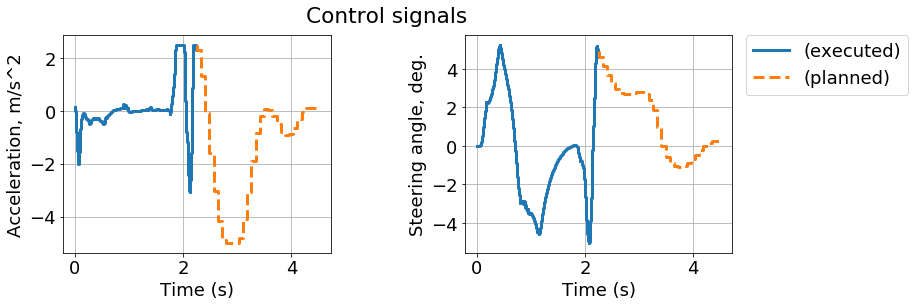

In [9]:
u_plt, u_ax1, u_ax2 = car.plot_u(u_plan, mpcprob.u_opt)

## x-y plot of car's path
Arrows show velocity. Orange components are planned but not executed.

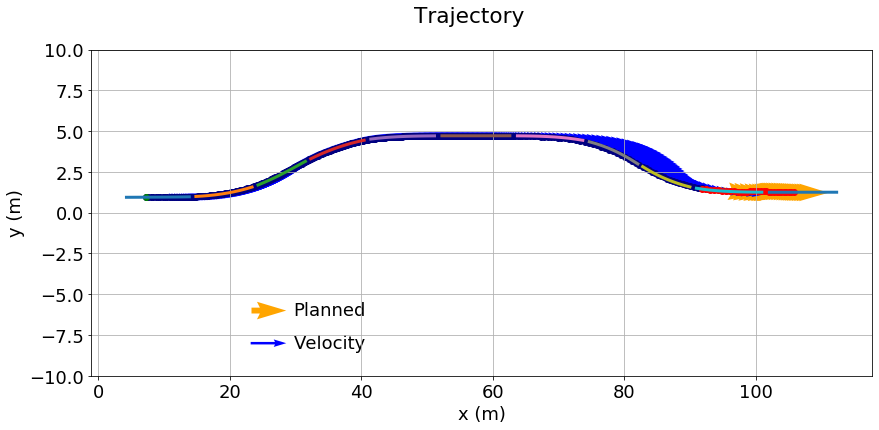

In [10]:
x_plt, x_ax = car.plot_x(x_plan, mpcprob.x_opt)
    
roadrunner.plot(ax=x_ax)
x_ax.scatter(ic[0], ic[1], color="green")
plt.ylim(-10,10)
plt.show()

## x vs time and y vs time, separately, with the boundaries

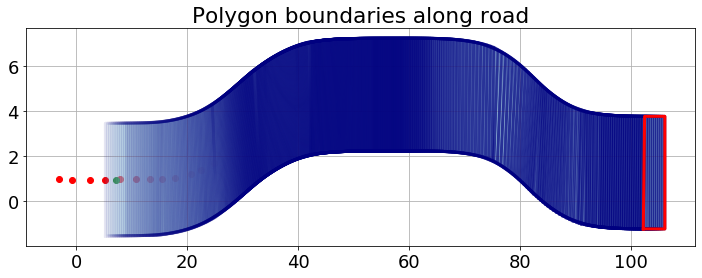

In [36]:
# Plot the road boundary as polygons
def plot_polygons(polygon_boundaries, ax=None):
    n_polys,_,_ = np.shape(polygon_boundaries)
    
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=(12,4))
        
    for k in range(n_polys):
        # Plot the polygon fill
        ax.fill(polygon_boundaries[k,:,0], polygon_boundaries[k,:,1], "lightblue", alpha=0.1+(k/(n_polys)/2))
        # Plot the line around each polygon
        ax.plot(np.concatenate([polygon_boundaries[k,:,0],polygon_boundaries[k,0:1,0]]),
                np.concatenate([polygon_boundaries[k,:,1],polygon_boundaries[k,0:1,1]]),
                color="navy", alpha=0.1+k/(n_polys)/2)

    # Plot the last polygon in RED
    ax.plot(np.concatenate([polygon_boundaries[-1,:,0],polygon_boundaries[-1,0:1,0]]),
            np.concatenate([polygon_boundaries[-1,:,1],polygon_boundaries[-1,0:1,1]]),
            color="red", alpha=1)
    return ax

ax = plot_polygons(polygon_boundaries)
ax.scatter(test_road[0:15,0], test_road[0:15,1], color='red')
ax.scatter(ic[0], ic[1], color="green")
plt.title("Polygon boundaries along road")
plt.show()